In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from datetime import datetime
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta = "/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/Datos.xlsx"
data_ventas = pd.read_excel(ruta, sheet_name=0)  # Hoja 1
data_calendario = pd.read_excel(ruta, sheet_name=1)  # Hoja 2
data_promos = pd.read_excel(ruta, sheet_name=2)  # Hoja 3
data_stock = pd.read_excel(ruta, sheet_name=3)  # Hoja 4

# **Ventas**

In [ ]:
data_ventas.head()

,producto,idSecuencia,udsVenta
0,1,20210403,30
1,1,20210404,0
2,1,20210405,0
3,1,20210406,45
4,1,20210407,59


In [ ]:
data_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707608 entries, 0 to 707607
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   producto     707608 non-null  int64
 1   idSecuencia  707608 non-null  int64
 2   udsVenta     707608 non-null  int64
dtypes: int64(3)
memory usage: 16.2 MB


In [ ]:
data_ventas.describe()

,producto,idSecuencia,udsVenta
count,707608.000000,7.076080e+05,707608.000000
mean,499.500000,2.021821e+07,3.781253
std,289.284031,6.469619e+03,6.788273
min,1.000000,2.021040e+07,-327.000000
25%,247.750000,2.021100e+07,0.000000
50%,499.500000,2.022040e+07,0.000000
75%,750.250000,2.022100e+07,5.000000
max,1000.000000,2.023040e+07,510.000000


Se convierte idSecuenta a tipo datetime:


In [ ]:
data_ventas['idSecuencia'] = pd.to_datetime(data_ventas['idSecuencia'], format='%Y%m%d')

In [ ]:
data_ventas.describe()

,producto,idSecuencia,udsVenta
count,707608.000000,707608,707608.000000
mean,499.500000,2022-04-02 23:59:59.999999488,3.781253
min,1.000000,2021-04-03 00:00:00,-327.000000
25%,247.750000,2021-10-02 00:00:00,0.000000
50%,499.500000,2022-04-03 00:00:00,0.000000
75%,750.250000,2022-10-03 00:00:00,5.000000
max,1000.000000,2023-04-03 00:00:00,510.000000
std,289.284031,NaN,6.788273


Se cuenta con los siguientes datos:

- `producto`: identificador único del anuncio. Se cuenta con mil productos: [1,1000]
- `idSecuencia`: fecha de venta. Se cuenta con datos desde el 03-04-2021 hasta el 03-04-2023.
- `udsVenta`: unidades vendidas. Se cuenta con datos negativos. Desde -327 uds hasta 510.

En total, el conjunto cuenta con 707608 registros

Revisamos si se cuenta con valores nulos

In [ ]:
data_ventas.isnull().sum()

producto       0
idSecuencia    0
udsVenta       0
dtype: int64

Revisamos si se cuenta con registros duplicados

In [ ]:
data_ventas.duplicated().sum()

0

Revisamos si se cuenta con unidades negativas

In [ ]:
# Filtrar las filas con unidades vendidas negativas
uds_negativas = data_ventas[data_ventas['udsVenta'] < 0]

# Mostrar las filas con unidades vendidas negativas
print(uds_negativas)

        producto idSecuencia  udsVenta
6299           9  2022-06-28       -99
6311           9  2022-07-10       -99
6354           9  2022-08-22      -173
14175         21  2022-01-14       -64
15565         23  2021-11-03        -5
...          ...         ...       ...
685205       970  2021-12-17        -5
687327       973  2021-10-07        -5
690906       978  2021-07-23       -10
702608       994  2021-07-29        -5
702845       994  2022-03-23        -5

[176 rows x 3 columns]


Tenemos 176 registros con valores negativos de udsVenta.

Vamos a visualizarlas

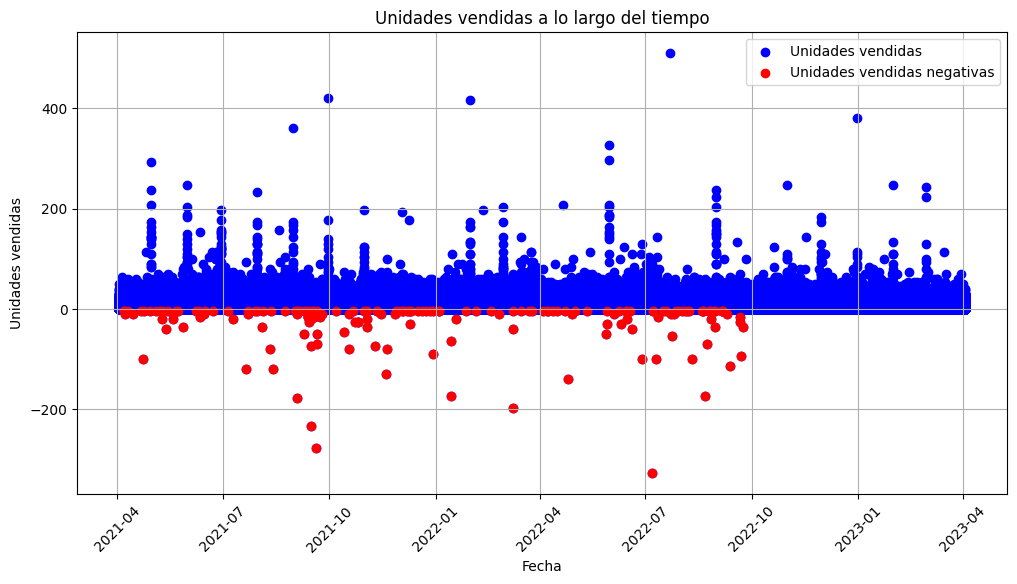

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(data_ventas['idSecuencia'], data_ventas['udsVenta'], c='blue', label='Unidades vendidas')
plt.scatter(uds_negativas['idSecuencia'], uds_negativas['udsVenta'], c='red', label='Unidades vendidas negativas')

plt.title('Unidades vendidas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Se observa que los negativos se concentran entre 2021 y el mes de octubre de 2022.

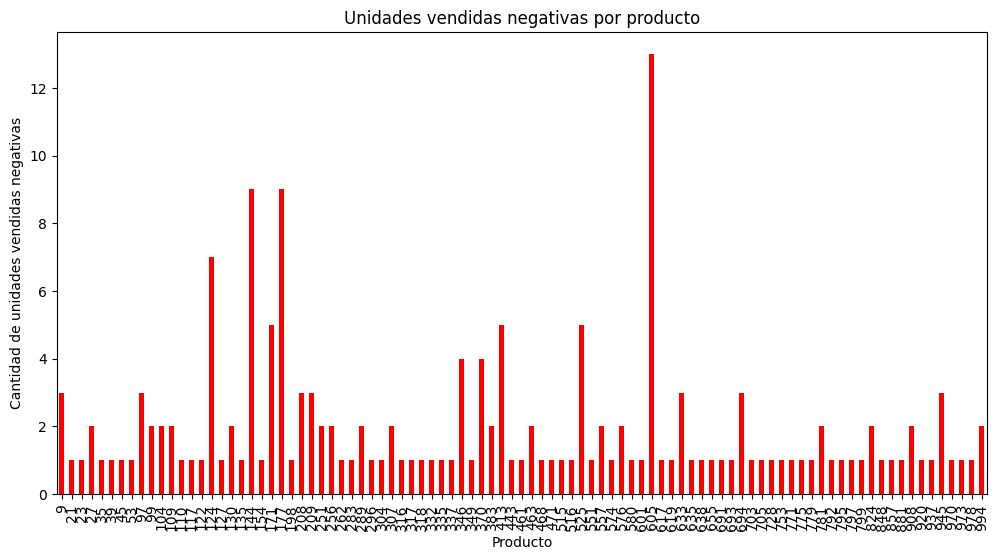

In [ ]:
uds_negativas_por_producto = uds_negativas.groupby('producto').size()


plt.figure(figsize=(12, 6))
uds_negativas_por_producto.plot(kind='bar', color='red')
plt.title('Unidades vendidas negativas por producto')
plt.xlabel('Producto')
plt.ylabel('Cantidad de unidades vendidas negativas')
plt.xticks(rotation=90)
plt.show()

Los negativos se concentran en los productos 605, 144 y 177.

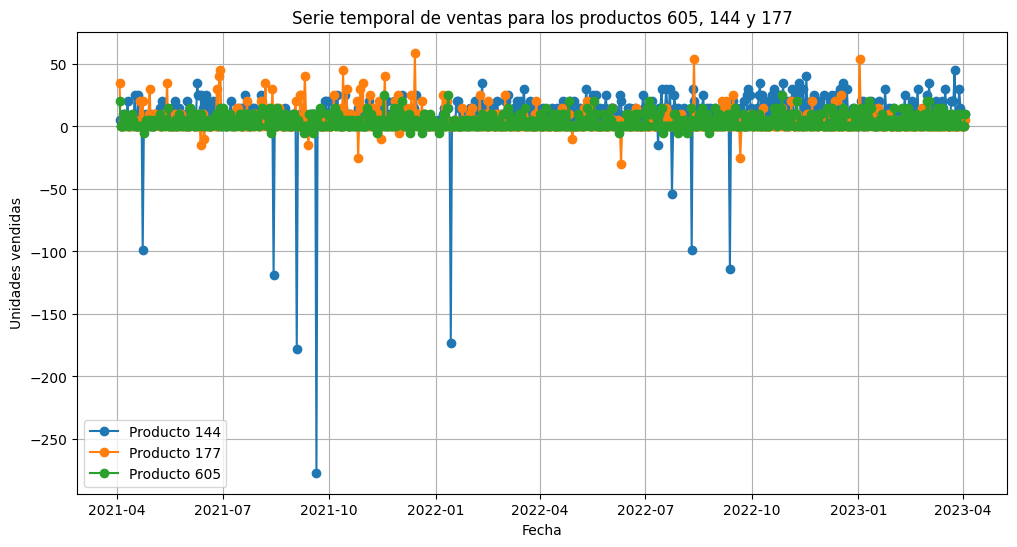

In [ ]:
# Filtrar los datos para incluir solo las filas correspondientes a los productos 605, 144 y 177
ventas_producto_605 = data_ventas[data_ventas['producto'] == 605]
ventas_producto_144 = data_ventas[data_ventas['producto'] == 144]
ventas_producto_177 = data_ventas[data_ventas['producto'] == 177]

# Ordenar los DataFrames por fecha
ventas_producto_605 = ventas_producto_605.sort_values(by='idSecuencia')
ventas_producto_144 = ventas_producto_144.sort_values(by='idSecuencia')
ventas_producto_177 = ventas_producto_177.sort_values(by='idSecuencia')

# Graficar las unidades vendidas en función de la fecha para el producto 144
plt.figure(figsize=(12, 6))
plt.plot(ventas_producto_144['idSecuencia'], ventas_producto_144['udsVenta'], marker='o', linestyle='-', label='Producto 144')
plt.title('Serie temporal de ventas para los productos 605, 144 y 177')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.grid(True)

plt.plot(ventas_producto_177['idSecuencia'], ventas_producto_177['udsVenta'], marker='o', linestyle='-', label='Producto 177')
plt.plot(ventas_producto_605['idSecuencia'], ventas_producto_605['udsVenta'], marker='o', linestyle='-', label='Producto 605')
plt.legend()
plt.show()

Estas unidades se van a modificar a 0 ya que suponemos que pueden ser errores electrónicos. **Luego del análisis del conjunto de datos integrado, se realizará este cambio.**

Ahora se revisarán los outliers de udsVenta.

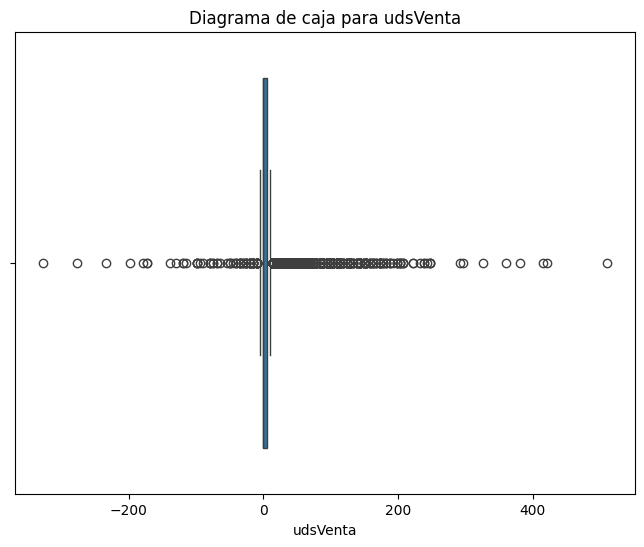

In [ ]:
# Crear un diagrama de caja para identificar outliers en udsVenta
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_ventas['udsVenta'])
plt.title('Diagrama de caja para udsVenta')
plt.xlabel('udsVenta')
plt.show()

Aparentemente, contamos con outliers. Al igual que las udsVenta negativas, vamos a continuar el análisis en la integración de datos de todos los conjuntos.

# **Calendario**

In [ ]:
data_calendario.head()

,idSecuencia,bolOpen,bolHoliday
0,20210804,1,0
1,20210805,1,0
2,20220528,1,0
3,20230421,1,0
4,20220525,1,0


In [ ]:
data_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   idSecuencia  830 non-null    int64
 1   bolOpen      830 non-null    int64
 2   bolHoliday   830 non-null    int64
dtypes: int64(3)
memory usage: 19.6 KB


In [ ]:
data_calendario.describe()

,idSecuencia,bolOpen,bolHoliday
count,8.300000e+02,830.000000,830.000000
mean,2.021970e+07,0.855422,0.162651
std,7.276925e+03,0.351887,0.369269
min,2.021040e+07,0.000000,0.000000
25%,2.021103e+07,1.000000,0.000000
50%,2.022052e+07,1.000000,0.000000
75%,2.022122e+07,1.000000,0.000000
max,2.023071e+07,1.000000,1.000000


Se convierte idSecuenta a tipo datetime:


In [ ]:
data_calendario['idSecuencia'] = pd.to_datetime(data_calendario['idSecuencia'], format='%Y%m%d')

In [ ]:
data_calendario.describe()

,idSecuencia,bolOpen,bolHoliday
count,830,830.000000,830.000000
mean,2022-05-23 12:00:00,0.855422,0.162651
min,2021-04-04 00:00:00,0.000000,0.000000
25%,2021-10-28 06:00:00,1.000000,0.000000
50%,2022-05-23 12:00:00,1.000000,0.000000
75%,2022-12-16 18:00:00,1.000000,0.000000
max,2023-07-12 00:00:00,1.000000,1.000000
std,NaN,0.351887,0.369269


Se cuenta con los siguientes datos:

- `idSecuencia`: dimensión de fecha. Se cuenta con datos desde el 04-04-2021 hasta el 12-07-2023.
- `bolOpen`: indicador booleano. Si es 1, indica apertura del punto de venta, 0 cierre del punto de venta.
- `bolHoliday`: indicador booleano. Si es 1, indica fecha festivo, 0 fecha no festiva.

En total, el conjunto cuenta con 830 registros.

Revisamos si se cuenta con valores nulos

In [ ]:
data_calendario.isnull().sum()

idSecuencia    0
bolOpen        0
bolHoliday     0
dtype: int64

Revisamos si se cuenta con registros duplicados.

In [ ]:
data_calendario.duplicated().sum()

0

# **Promociones**

In [ ]:
data_promos.head()

,producto,idSecuenciaIni,idSecuenciaFin
0,577,20141029,20141121
1,836,20210715,20210815
2,829,20150410,20150611
3,156,20170420,20170520
4,48,20160714,20160815


In [ ]:
data_promos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26087 entries, 0 to 26086
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   producto        26087 non-null  int64
 1   idSecuenciaIni  26087 non-null  int64
 2   idSecuenciaFin  26087 non-null  int64
dtypes: int64(3)
memory usage: 611.5 KB


In [ ]:
data_promos.describe()

,producto,idSecuenciaIni,idSecuenciaFin
count,26087.000000,2.608700e+04,2.608700e+04
mean,438.767010,2.018103e+07,2.018192e+07
std,293.472291,3.057438e+04,3.047187e+04
min,1.000000,2.011010e+07,2.011011e+07
25%,173.000000,2.016061e+07,2.016071e+07
50%,416.000000,2.018121e+07,2.019011e+07
75%,683.000000,2.021031e+07,2.021041e+07
max,999.000000,2.023042e+07,2.023052e+07


Vamos a convertir idSecuenciaIni e idSecuenciaFin en formato fecha.

In [ ]:
data_promos['idSecuenciaIni'] = pd.to_datetime(data_promos['idSecuenciaIni'], format='%Y%m%d')
data_promos['idSecuenciaFin'] = pd.to_datetime(data_promos['idSecuenciaFin'], format='%Y%m%d')

In [ ]:
data_promos.describe()

,producto,idSecuenciaIni,idSecuenciaFin
count,26087.000000,26087,26087
mean,438.767010,2018-07-10 16:38:53.852110336,2018-08-12 20:59:43.026028288
min,1.000000,2011-01-04 00:00:00,2011-01-11 00:00:00
25%,173.000000,2016-06-10 00:00:00,2016-07-10 00:00:00
50%,416.000000,2018-12-13 00:00:00,2019-01-10 00:00:00
75%,683.000000,2021-03-11 00:00:00,2021-04-07 00:00:00
max,999.000000,2023-04-20 00:00:00,2023-05-17 00:00:00
std,293.472291,NaN,NaN


Se cuenta con los siguientes datos:

- `producto`: identificador del producto [1,1000]
- `idSecuenciaIni`: fecha de inicio de promoción. Desde el 04-01-2011 hasta el 20-04-2023.
- `idSecuenciaFin`: fecha de fin de promoción. Desde el 11-01-2011 hasta el 07-05-2023.

En total, el conjunto cuenta con 26087 registros.

Revisamos si tiene nulos

In [ ]:
data_promos.isnull().sum()

producto          0
idSecuenciaIni    0
idSecuenciaFin    0
dtype: int64

Revisamos si tiene duplicados


In [ ]:
data_promos.duplicated().sum()

1

In [ ]:
data_promos.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
26082    False
26083    False
26084    False
26085    False
26086     True
Length: 26087, dtype: bool

In [ ]:
data_promos.tail()

,producto,idSecuenciaIni,idSecuenciaFin
26082,83,2021-01-14,2021-03-07
26083,764,2017-08-17,2017-09-04
26084,409,2019-11-08,2019-12-08
26085,760,2012-01-12,2012-03-13
26086,610,2021-03-11,2021-04-07


In [ ]:
data_promos[data_promos['producto'] == 610]

,producto,idSecuenciaIni,idSecuenciaFin
1994,610,2021-09-01,2021-09-22
2433,610,2020-08-25,2020-09-09
2677,610,2020-12-10,2021-01-13
4092,610,2020-03-24,2020-04-14
4730,610,2020-05-11,2020-06-11
4744,610,2022-02-24,2022-03-23
6792,610,2022-04-21,2022-05-18
10037,610,2021-07-15,2021-08-15
11989,610,2022-07-14,2022-08-10
12030,610,2019-12-10,2020-01-10


Se observa que los registros 25106 y 26086 son iguales. Vamos a eliminar uno de ellos.

In [ ]:
data_promos=data_promos.drop_duplicates()

In [ ]:
data_promos.duplicated().sum()

0

Vamos a ver cuantos productos únicos estuvieron en promoción.

In [ ]:
data_promos['producto'].nunique()

681

# **Stock**

In [ ]:
data_stock.head()

,producto,idSecuencia,udsStock
0,222,20210404,188
1,222,20210405,188
2,222,20210406,188
3,222,20210407,238
4,222,20210408,238


In [ ]:
data_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707608 entries, 0 to 707607
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   producto     707608 non-null  int64
 1   idSecuencia  707608 non-null  int64
 2   udsStock     707608 non-null  int64
dtypes: int64(3)
memory usage: 16.2 MB


In [ ]:
data_stock.describe()

,producto,idSecuencia,udsStock
count,707608.000000,7.076080e+05,707608.000000
mean,499.500000,2.021823e+07,127.028288
std,289.284031,6.478850e+03,131.422303
min,1.000000,2.021040e+07,-149.000000
25%,247.750000,2.021100e+07,69.000000
50%,499.500000,2.022040e+07,104.000000
75%,750.250000,2.022100e+07,144.000000
max,1000.000000,2.023040e+07,2460.000000


Vamos a convertir idSecuencia en fecha.

In [ ]:
data_stock['idSecuencia'] = pd.to_datetime(data_stock['idSecuencia'], format='%Y%m%d')

In [ ]:
data_stock.describe()

,producto,idSecuencia,udsStock
count,707608.000000,707608,707608.000000
mean,499.500000,2022-04-04 00:00:00.000000256,127.028288
min,1.000000,2021-04-04 00:00:00,-149.000000
25%,247.750000,2021-10-03 00:00:00,69.000000
50%,499.500000,2022-04-04 00:00:00,104.000000
75%,750.250000,2022-10-04 00:00:00,144.000000
max,1000.000000,2023-04-04 00:00:00,2460.000000
std,289.284031,NaN,131.422303


Se cuenta con los siguientes datos:

- `producto`: identificador único del anuncio. Se cuenta con mil productos: [1,1000]
- `idSecuencia`: fecha de stock. Se cuenta con datos desde el 03-04-2021 hasta el 03-04-2023.
- `udsStock`: unidades en stock. Se cuenta con datos negativos. Desde -149 uds hasta 2460.

En total, el conjunto cuenta con 707608 registros

Revisamos si hay nulos

In [ ]:
data_stock.isnull().sum()

producto       0
idSecuencia    0
udsStock       0
dtype: int64

Revisamos si hay duplicados

In [ ]:
data_stock.duplicated().sum()

0

Vamos a ver los negativos de udsStock

In [ ]:
# Filtrar las filas con unidades vendidas negativas
uds_negativas_stock = data_stock[data_stock['udsStock'] < 0]

# Mostrar las filas con unidades vendidas negativas
print(uds_negativas_stock)

        producto idSecuencia  udsStock
2789         448  2021-11-01       -54
3905         450  2021-11-26        -5
3906         450  2021-11-27        -5
3907         450  2021-11-28        -5
3908         450  2021-11-29        -5
...          ...         ...       ...
699338       205  2021-10-19        -5
699385       205  2021-10-20        -5
699386       205  2021-10-21        -5
699387       205  2021-10-22        -5
700252       204  2021-11-01       -10

[1353 rows x 3 columns]


Tenemos 1353 registros con udsStock negativas.

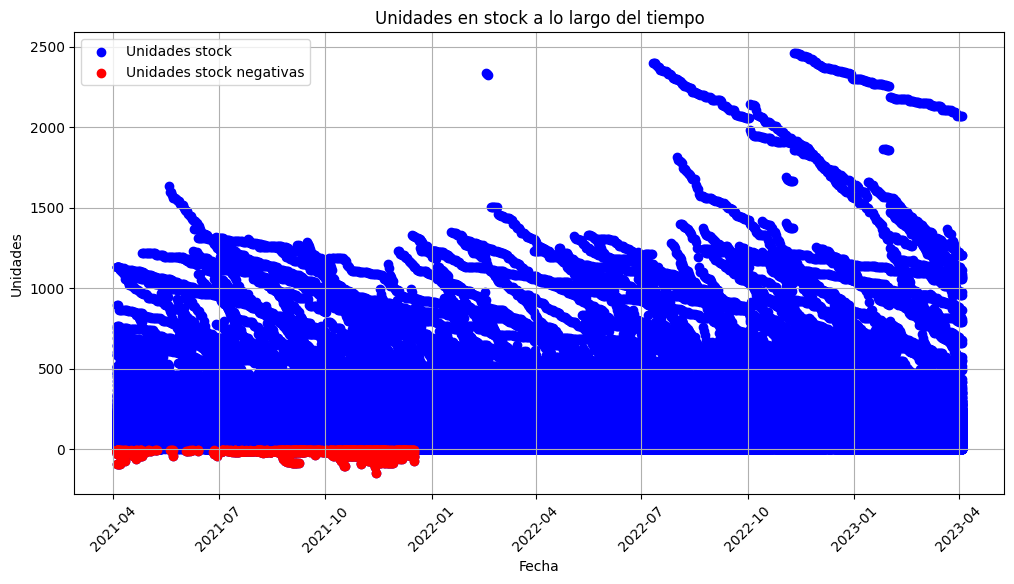

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(data_stock['idSecuencia'], data_stock['udsStock'], c='blue', label='Unidades stock')
plt.scatter(uds_negativas_stock['idSecuencia'], uds_negativas_stock['udsStock'], c='red', label='Unidades stock negativas')

plt.title('Unidades en stock a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Como se puede observar, se concentran en el año 2021.

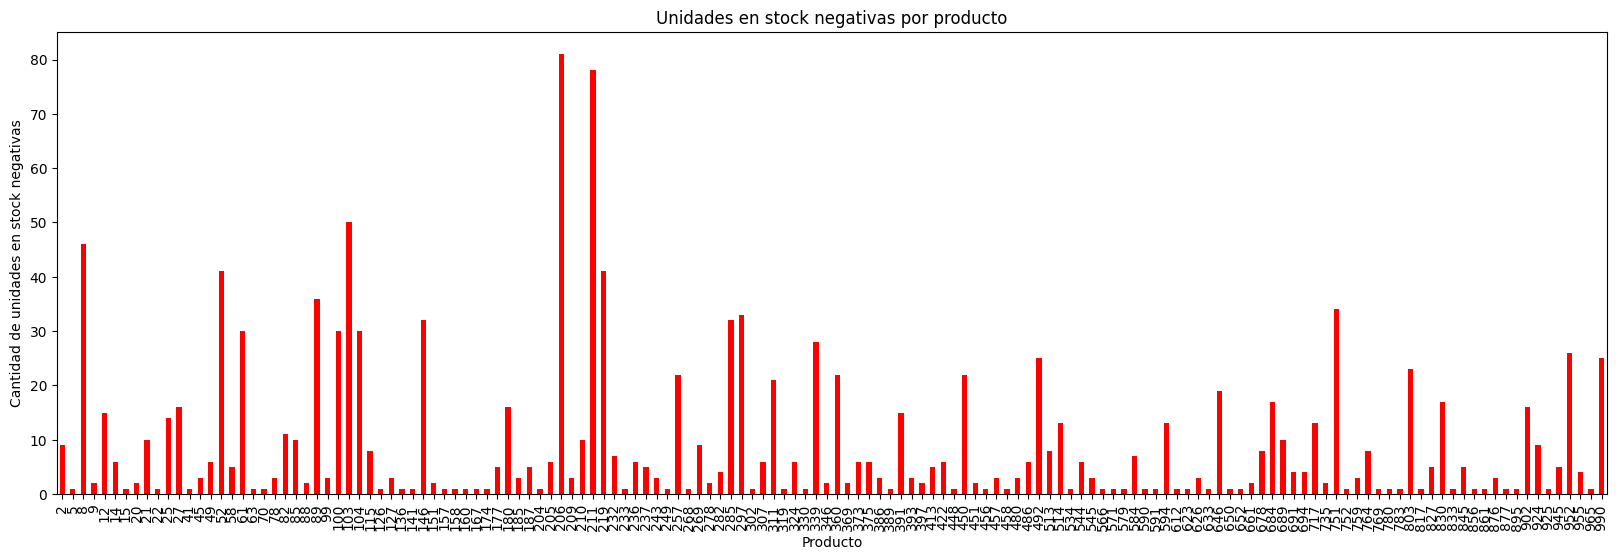

In [ ]:
uds_negativas_por_producto_stock = uds_negativas_stock.groupby('producto').size()


plt.figure(figsize=(20, 6))
uds_negativas_por_producto_stock.plot(kind='bar', color='red')
plt.title('Unidades en stock negativas por producto')
plt.xlabel('Producto')
plt.ylabel('Cantidad de unidades en stock negativas')
plt.xticks(rotation=90)
plt.show()

Existen dos productos con más negativos que el resto, 206 y 211.

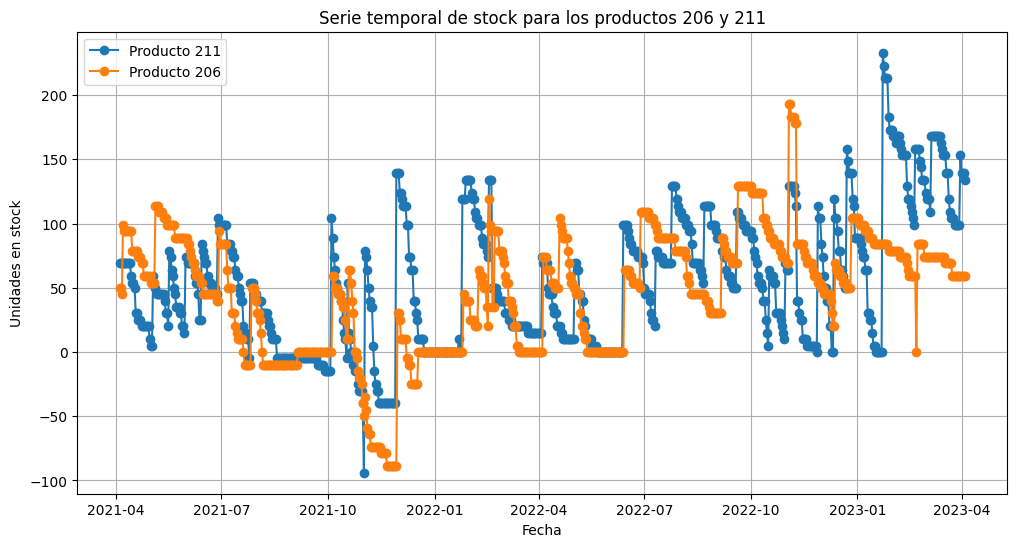

In [ ]:
# Filtrar los datos para incluir solo las filas correspondientes a los productos 206 y 211
stock_producto_206 = data_stock[data_stock['producto'] == 206]
stock_producto_211 = data_stock[data_stock['producto'] == 211]

# Ordenar los DataFrames por fecha
stock_producto_206 = stock_producto_206.sort_values(by='idSecuencia')
stock_producto_211 = stock_producto_211.sort_values(by='idSecuencia')


plt.figure(figsize=(12, 6))
plt.plot(stock_producto_211['idSecuencia'], stock_producto_211['udsStock'], marker='o', linestyle='-', label='Producto 211')
plt.title('Serie temporal de stock para los productos 206 y 211')
plt.xlabel('Fecha')
plt.ylabel('Unidades en stock')
plt.grid(True)

plt.plot(stock_producto_206['idSecuencia'], stock_producto_206['udsStock'], marker='o', linestyle='-', label='Producto 206')
plt.legend()
plt.show()

Estas unidades se van a modificar a 0 ya que suponemos que pueden ser errores electrónicos. **Luego del análisis del conjunto de datos integrado, se realizará este cambio.**

Ahora revisaremos los outliers.

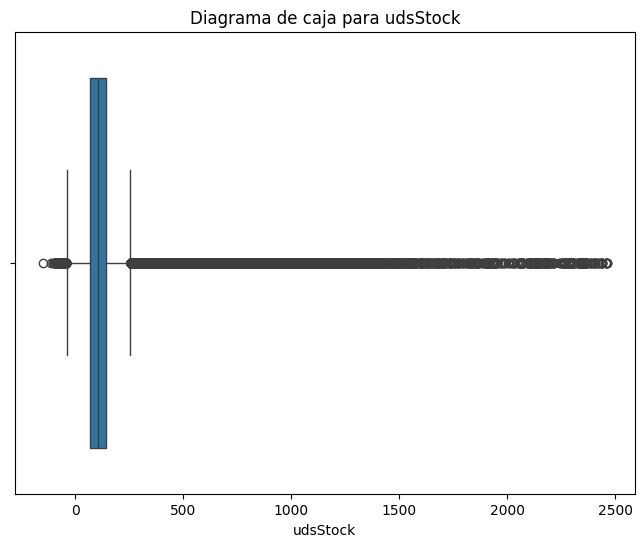

In [ ]:
# Crear un diagrama de caja para identificar outliers en udsVenta
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_stock['udsStock'])
plt.title('Diagrama de caja para udsStock')
plt.xlabel('udsStock')
plt.show()

Aparentemente, contamos con outliers. Al igual que las udsStock negativas, vamos a continuar el análisis en la integración de datos de todos los conjuntos.

# **Conjunto de datos integrado**

Una vez revisados los 4 conjuntos de datos de manera individual, en esta sección vamos a proceder a unirlos de manera que solo nos quede uno para realizar un análisis exhaustivo.

En primer lugar, vamos a revisar los valores negativos de udsVentas y udsStock con varias gráficas de apoyo, tomando de ejemplo algún producto concreto.

Para ello, vamos a crear dos features temporales para cada conjunto, "año" y "mes"

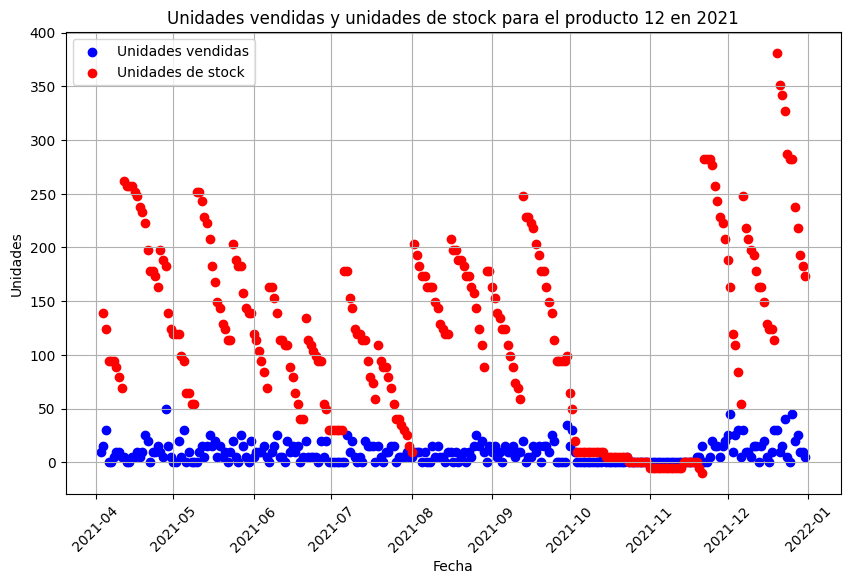

In [ ]:
# Filtrar los datos de ventas para el producto 12 en el año 2021
data_ventas['año'] = data_ventas['idSecuencia'].dt.year
datos_producto_ventas = data_ventas[(data_ventas['producto'] == 12) & (data_ventas['año'] == 2021)]

# Filtrar los datos de stock para el producto 12 en el año 2021
data_stock['año'] = data_stock['idSecuencia'].dt.year
datos_producto_stock = data_stock[(data_stock['producto'] == 12) & (data_stock['año'] == 2021)]

# Crear un scatterplot con udsVenta y udsStock para el producto 12
plt.figure(figsize=(10, 6))
plt.scatter(datos_producto_ventas['idSecuencia'], datos_producto_ventas['udsVenta'], color='blue', label='Unidades vendidas')
plt.scatter(datos_producto_stock['idSecuencia'], datos_producto_stock['udsStock'], color='red', label='Unidades de stock')
plt.title('Unidades vendidas y unidades de stock para el producto 12 en 2021')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


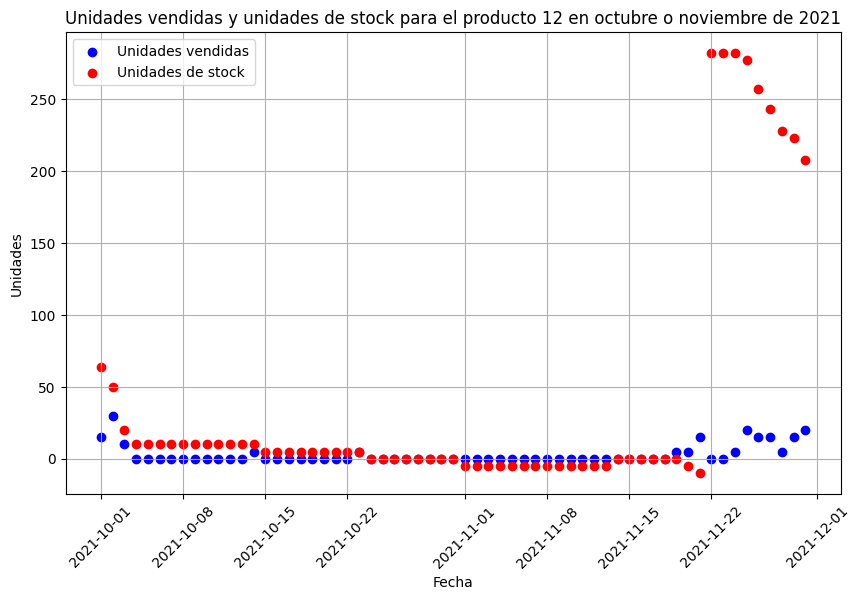

In [ ]:
# Filtrar los datos de ventas para el producto 12 en el año 2021 y el mes 10 o 11
data_ventas['mes'] = data_ventas['idSecuencia'].dt.month
datos_producto_ventas = data_ventas[(data_ventas['producto'] == 12) & (data_ventas['año'] == 2021) & ((data_ventas['mes'] == 10) | (data_ventas['mes'] == 11))]

# Filtrar los datos de stock para el producto 12 en el año 2021 y el mes 10 o 11
data_stock['mes'] = data_stock['idSecuencia'].dt.month
datos_producto_stock = data_stock[(data_stock['producto'] == 12) & (data_stock['año'] == 2021) & ((data_stock['mes'] == 10) | (data_stock['mes'] == 11))]

# Crear un scatterplot con udsVenta y udsStock para el producto 12 en octubre o noviembre de 2021
plt.figure(figsize=(10, 6))
plt.scatter(datos_producto_ventas['idSecuencia'], datos_producto_ventas['udsVenta'], color='blue', label='Unidades vendidas')
plt.scatter(datos_producto_stock['idSecuencia'], datos_producto_stock['udsStock'], color='red', label='Unidades de stock')
plt.title('Unidades vendidas y unidades de stock para el producto 12 en octubre o noviembre de 2021')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


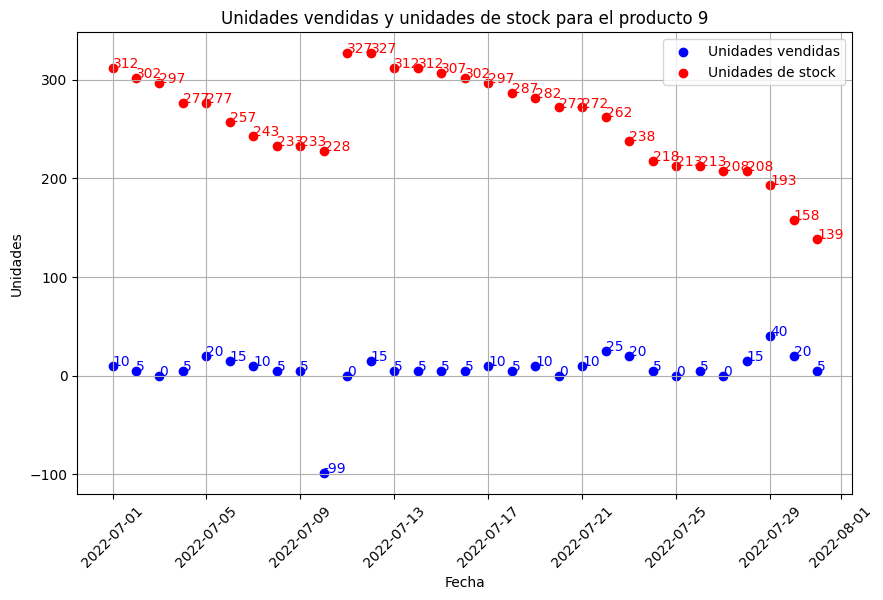

In [ ]:
# Filtrar los datos de ventas para el producto 9 en el año 2022 y el mes 7
datos_producto_ventas = data_ventas[(data_ventas['producto'] == 9) & (data_ventas['año'] == 2022) & ((data_ventas['mes'] == 7))]

# Filtrar los datos de stock para el producto 9 en el año 2022 y el mes 7
datos_producto_stock = data_stock[(data_stock['producto'] == 9) & (data_stock['año'] == 2022) & ((data_stock['mes'] == 7) )]

# Crear un scatterplot con udsVenta y udsStock para el producto 9 en el año 2022 y el mes 7
plt.figure(figsize=(10, 6))
plt.scatter(datos_producto_ventas['idSecuencia'], datos_producto_ventas['udsVenta'], color='blue', label='Unidades vendidas')
plt.scatter(datos_producto_stock['idSecuencia'], datos_producto_stock['udsStock'], color='red', label='Unidades de stock')

# Agregar etiquetas a cada punto del scatterplot
for x, y, venta in zip(datos_producto_ventas['idSecuencia'], datos_producto_ventas['udsVenta'], datos_producto_ventas['udsVenta']):
    plt.text(x, y, str(venta), color='blue')

for x, y, stock in zip(datos_producto_stock['idSecuencia'], datos_producto_stock['udsStock'], datos_producto_stock['udsStock']):
    plt.text(x, y, str(stock), color='red')

plt.title('Unidades vendidas y unidades de stock para el producto 9')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


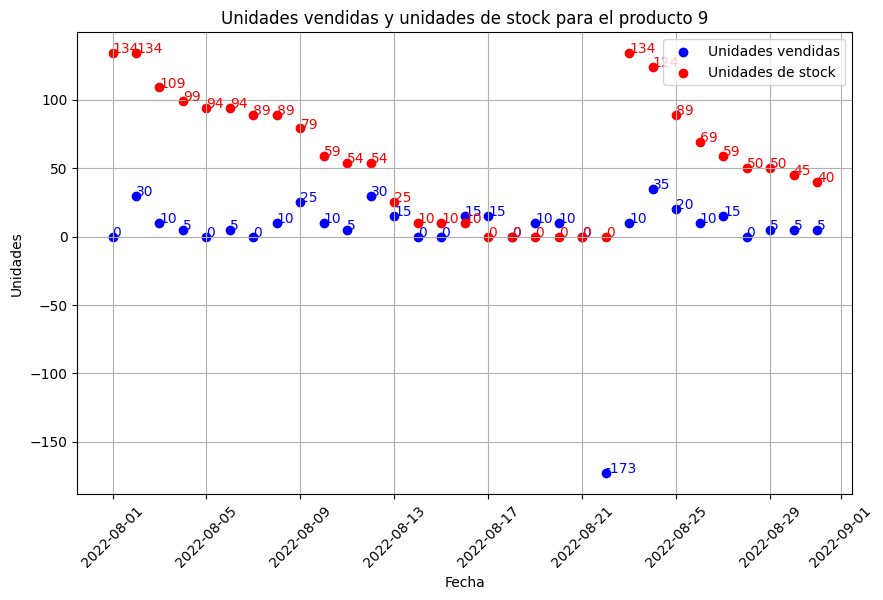

In [ ]:
# Filtrar los datos de ventas para el producto 9 en el año 2022 y el mes 8
datos_producto_ventas = data_ventas[(data_ventas['producto'] == 9) & (data_ventas['año'] == 2022) & ((data_ventas['mes'] == 8))]

# Filtrar los datos de stock para el producto 9 en el año 2022 y el mes 8
datos_producto_stock = data_stock[(data_stock['producto'] == 9) & (data_stock['año'] == 2022) & ((data_stock['mes'] == 8) )]

# Crear un scatterplot con udsVenta y udsStock para el producto 9 en el año 2022 y el mes 8
plt.figure(figsize=(10, 6))
plt.scatter(datos_producto_ventas['idSecuencia'], datos_producto_ventas['udsVenta'], color='blue', label='Unidades vendidas')
plt.scatter(datos_producto_stock['idSecuencia'], datos_producto_stock['udsStock'], color='red', label='Unidades de stock')

# Agregar etiquetas a cada punto del scatterplot
for x, y, venta in zip(datos_producto_ventas['idSecuencia'], datos_producto_ventas['udsVenta'], datos_producto_ventas['udsVenta']):
    plt.text(x, y, str(venta), color='blue')

for x, y, stock in zip(datos_producto_stock['idSecuencia'], datos_producto_stock['udsStock'], datos_producto_stock['udsStock']):
    plt.text(x, y, str(stock), color='red')

plt.title('Unidades vendidas y unidades de stock para el producto 9')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


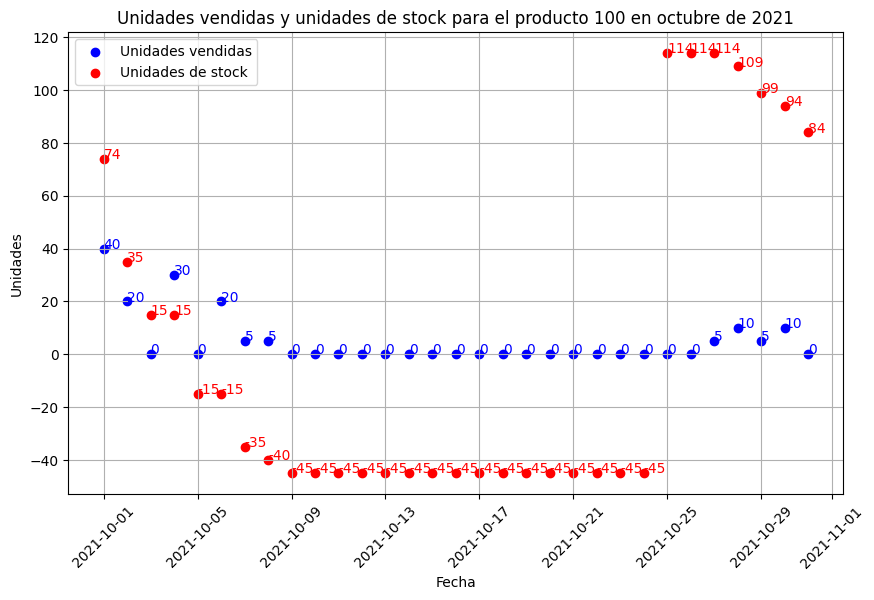

In [ ]:
# Filtrar los datos de ventas para el producto 100 en el año 2021 y el mes 10
datos_producto_ventas = data_ventas[(data_ventas['producto'] == 100) & (data_ventas['año'] == 2021) & ((data_ventas['mes'] == 10) )]

# Filtrar los datos de stock para el producto 100 en el año 2021 y el mes 10
datos_producto_stock = data_stock[(data_stock['producto'] == 100) & (data_stock['año'] == 2021) & ((data_stock['mes'] == 10) )]

# Crear un scatterplot con udsVenta y udsStock para el producto 100 en octubre de 2021
plt.figure(figsize=(10, 6))
plt.scatter(datos_producto_ventas['idSecuencia'], datos_producto_ventas['udsVenta'], color='blue', label='Unidades vendidas')
plt.scatter(datos_producto_stock['idSecuencia'], datos_producto_stock['udsStock'], color='red', label='Unidades de stock')

# Agregar etiquetas a cada punto del scatterplot
for x, y, venta in zip(datos_producto_ventas['idSecuencia'], datos_producto_ventas['udsVenta'], datos_producto_ventas['udsVenta']):
    plt.text(x, y, str(venta), color='blue')

for x, y, stock in zip(datos_producto_stock['idSecuencia'], datos_producto_stock['udsStock'], datos_producto_stock['udsStock']):
    plt.text(x, y, str(stock), color='red')

plt.title('Unidades vendidas y unidades de stock para el producto 100 en octubre de 2021')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Con estas gráficas podemos ver que las unidades negativas de udsVentas y udsStock son anómalas, por lo que podemos confirmar de que se trata de algún tipo de error. **Como solución se propone sustituir los valores por 0**.

In [ ]:
data_ventas.loc[data_ventas['udsVenta'] < 0, 'udsVenta'] = 0
data_stock.loc[data_stock['udsStock'] < 0, 'udsStock'] = 0

Ahora procedemos con la integración de las tablas:

In [ ]:
data_ventas_stock = pd.merge(data_ventas, data_stock, on=['idSecuencia', 'producto'], how="outer")

In [ ]:
data_ventas_stock_calendario = pd.merge(data_ventas_stock, data_calendario, on=['idSecuencia'], how="left")

In [ ]:
data_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708576 entries, 0 to 708575
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     708576 non-null  int64         
 1   idSecuencia  708576 non-null  datetime64[ns]
 2   udsVenta     707608 non-null  float64       
 3   año_x        707608 non-null  float64       
 4   mes_x        707608 non-null  float64       
 5   udsStock     707608 non-null  float64       
 6   año_y        707608 non-null  float64       
 7   mes_y        707608 non-null  float64       
 8   bolOpen      707608 non-null  float64       
 9   bolHoliday   707608 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 54.1 MB


Creamos una variable estaEnPromocion para los días en los que el producto se encuentra en promoción.

In [ ]:
# Primero, inicializamos la columna 'estaEnPromocion' en data_ventas_stock_calendario con 0 (False)
data_ventas_stock_calendario['estaEnPromocion'] = 0

# Función para actualizar la columna 'estaEnPromocion'
def update_promotion_status(row):
    # Filtramos data_promos para el producto de la fila actual
    promos = data_promos[data_promos['producto'] == row['producto']]

    # Revisamos si idSecuencia está dentro de algún rango de promoción
    for _, promo in promos.iterrows():
        if promo['idSecuenciaIni'] <= row['idSecuencia'] <= promo['idSecuenciaFin']:
            return 1  # Retorna 1 si está en promoción
    return 0  # Retorna 0 si no está en promoción

# Aplicamos la función a cada fila del DataFrame data_ventas_stock_calendario
data_ventas_stock_calendario['estaEnPromocion'] = data_ventas_stock_calendario.apply(update_promotion_status, axis=1)

# Verificamos los resultados
print(data_ventas_stock_calendario.head())

   producto idSecuencia  udsVenta   año_x  mes_x  udsStock   año_y  mes_y  \
0         1  2021-04-03      30.0  2021.0    4.0       NaN     NaN    NaN   
1         1  2021-04-04       0.0  2021.0    4.0     604.0  2021.0    4.0   
2         1  2021-04-05       0.0  2021.0    4.0     604.0  2021.0    4.0   
3         1  2021-04-06      45.0  2021.0    4.0     604.0  2021.0    4.0   
4         1  2021-04-07      59.0  2021.0    4.0     554.0  2021.0    4.0   

   bolOpen  bolHoliday  estaEnPromocion  
0      NaN         NaN                1  
1      0.0         1.0                1  
2      0.0         1.0                1  
3      1.0         0.0                1  
4      1.0         0.0                1  


In [ ]:
data_ventas_stock_calendario.describe()

,producto,idSecuencia,udsVenta,año_x,mes_x,udsStock,año_y,mes_y,bolOpen,bolHoliday,estaEnPromocion
count,708576.000000,708576,707608.000000,707608.000000,707608.000000,707608.000000,707608.000000,707608.000000,707608.000000,707608.000000,708576.000000
mean,499.500000,2022-04-03 11:59:59.999999488,3.788360,2021.753762,6.522572,127.063418,2021.756498,6.522572,0.844049,0.176471,0.242224
min,1.000000,2021-04-03 00:00:00,0.000000,2021.000000,1.000000,0.000000,2021.000000,1.000000,0.000000,0.000000,0.000000
25%,247.750000,2021-10-02 18:00:00,0.000000,2021.000000,4.000000,69.000000,2021.000000,4.000000,1.000000,0.000000,0.000000
50%,499.500000,2022-04-03 12:00:00,0.000000,2022.000000,7.000000,104.000000,2022.000000,7.000000,1.000000,0.000000,0.000000
75%,750.250000,2022-10-03 06:00:00,5.000000,2022.000000,10.000000,144.000000,2022.000000,10.000000,1.000000,0.000000,0.000000
max,1000.000000,2023-04-04 00:00:00,510.000000,2023.000000,12.000000,2460.000000,2023.000000,12.000000,1.000000,1.000000,1.000000
std,289.284031,NaN,6.723272,0.663364,3.446759,131.383082,0.664373,3.446759,0.362809,0.381220,0.428429


In [ ]:
data_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708576 entries, 0 to 708575
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   producto         708576 non-null  int64         
 1   idSecuencia      708576 non-null  datetime64[ns]
 2   udsVenta         707608 non-null  float64       
 3   año_x            707608 non-null  float64       
 4   mes_x            707608 non-null  float64       
 5   udsStock         707608 non-null  float64       
 6   año_y            707608 non-null  float64       
 7   mes_y            707608 non-null  float64       
 8   bolOpen          707608 non-null  float64       
 9   bolHoliday       707608 non-null  float64       
 10  estaEnPromocion  708576 non-null  int64         
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 59.5 MB


Se van a eliminar las columnas duplicadas por el outer join y se redefinen.

In [ ]:
data_ventas_stock_calendario = data_ventas_stock_calendario.drop(['año_x', 'mes_x', 'año_y', 'mes_y'], axis=1)

In [ ]:
data_ventas_stock_calendario['año'] = data_ventas_stock_calendario['idSecuencia'].dt.year
data_ventas_stock_calendario['mes'] = data_ventas_stock_calendario['idSecuencia'].dt.month
data_ventas_stock_calendario['dia'] = data_ventas_stock_calendario['idSecuencia'].dt.day

In [ ]:
data_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708576 entries, 0 to 708575
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   producto         708576 non-null  int64         
 1   idSecuencia      708576 non-null  datetime64[ns]
 2   udsVenta         707608 non-null  float64       
 3   udsStock         707608 non-null  float64       
 4   bolOpen          707608 non-null  float64       
 5   bolHoliday       707608 non-null  float64       
 6   estaEnPromocion  708576 non-null  int64         
 7   año              708576 non-null  int32         
 8   mes              708576 non-null  int32         
 9   dia              708576 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(3), int64(2)
memory usage: 46.0 MB


Revisamos posibles nulos debido al join, además de los tipos.

In [ ]:
nan_counts = data_ventas_stock_calendario.isnull().sum()

# Imprimir el conteo de NaN
print(nan_counts)

producto             0
idSecuencia          0
udsVenta           968
udsStock           968
bolOpen            968
bolHoliday         968
estaEnPromocion      0
año                  0
mes                  0
dia                  0
dtype: int64


In [ ]:
data_ventas_stock_calendario[data_ventas_stock_calendario['udsVenta'].isnull()]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia
707608,2,2023-04-04,NaN,515.0,1.0,0.0,0,2023,4,4
707609,223,2023-04-04,NaN,119.0,1.0,0.0,0,2023,4,4
707610,225,2023-04-04,NaN,40.0,1.0,0.0,0,2023,4,4
707611,222,2023-04-04,NaN,257.0,1.0,0.0,0,2023,4,4
707612,451,2023-04-04,NaN,0.0,1.0,0.0,0,2023,4,4
...,...,...,...,...,...,...,...,...,...,...
708571,198,2023-04-04,NaN,233.0,1.0,0.0,0,2023,4,4
708572,197,2023-04-04,NaN,173.0,1.0,0.0,0,2023,4,4
708573,196,2023-04-04,NaN,0.0,1.0,0.0,0,2023,4,4
708574,195,2023-04-04,NaN,139.0,1.0,0.0,0,2023,4,4


Existe un día que tenemos stock pero no tenemos datos de ventas. Lo vamos a eliminar del conjunto.

In [ ]:
data_ventas_stock_calendario=data_ventas_stock_calendario.dropna()

In [ ]:
nan_counts = data_ventas_stock_calendario.isnull().sum()

# Imprimir el conteo de NaN
print(nan_counts)

producto           0
idSecuencia        0
udsVenta           0
udsStock           0
bolOpen            0
bolHoliday         0
estaEnPromocion    0
año                0
mes                0
dia                0
dtype: int64


Convertimos a int las columnas

In [ ]:
columnas_a_convertir = ['producto', 'udsVenta', 'udsStock', 'bolOpen', 'bolHoliday', 'año', 'estaEnPromocion', 'mes', 'dia']
data_ventas_stock_calendario[columnas_a_convertir] = data_ventas_stock_calendario[columnas_a_convertir].astype(int)

In [ ]:
data_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
Index: 706640 entries, 1 to 707607
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   producto         706640 non-null  int64         
 1   idSecuencia      706640 non-null  datetime64[ns]
 2   udsVenta         706640 non-null  int64         
 3   udsStock         706640 non-null  int64         
 4   bolOpen          706640 non-null  int64         
 5   bolHoliday       706640 non-null  int64         
 6   estaEnPromocion  706640 non-null  int64         
 7   año              706640 non-null  int64         
 8   mes              706640 non-null  int64         
 9   dia              706640 non-null  int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 59.3 MB


Features temporales

Creamos la columna dia de la semana, semana del mes y semana del año además de año, mes y día.

In [ ]:
# Crear la columna de día de la semana (0: lunes, 1: martes, ..., 6: domingo)
data_ventas_stock_calendario['dia_semana'] = data_ventas_stock_calendario['idSecuencia'].dt.dayofweek

# Crear la columna de semana del mes (0: primera semana, 1: segunda semana, ..., n: última semana)
data_ventas_stock_calendario['semana_mes'] = data_ventas_stock_calendario['idSecuencia'].dt.day // 7

# Crear la columna de semana del año
data_ventas_stock_calendario['semana_año'] = data_ventas_stock_calendario['idSecuencia'].dt.isocalendar().week

# **Análisis conjunto**

Una vez tenemos el conjunto de datos final, vamos a realizar un análisis de las ventas y stock.

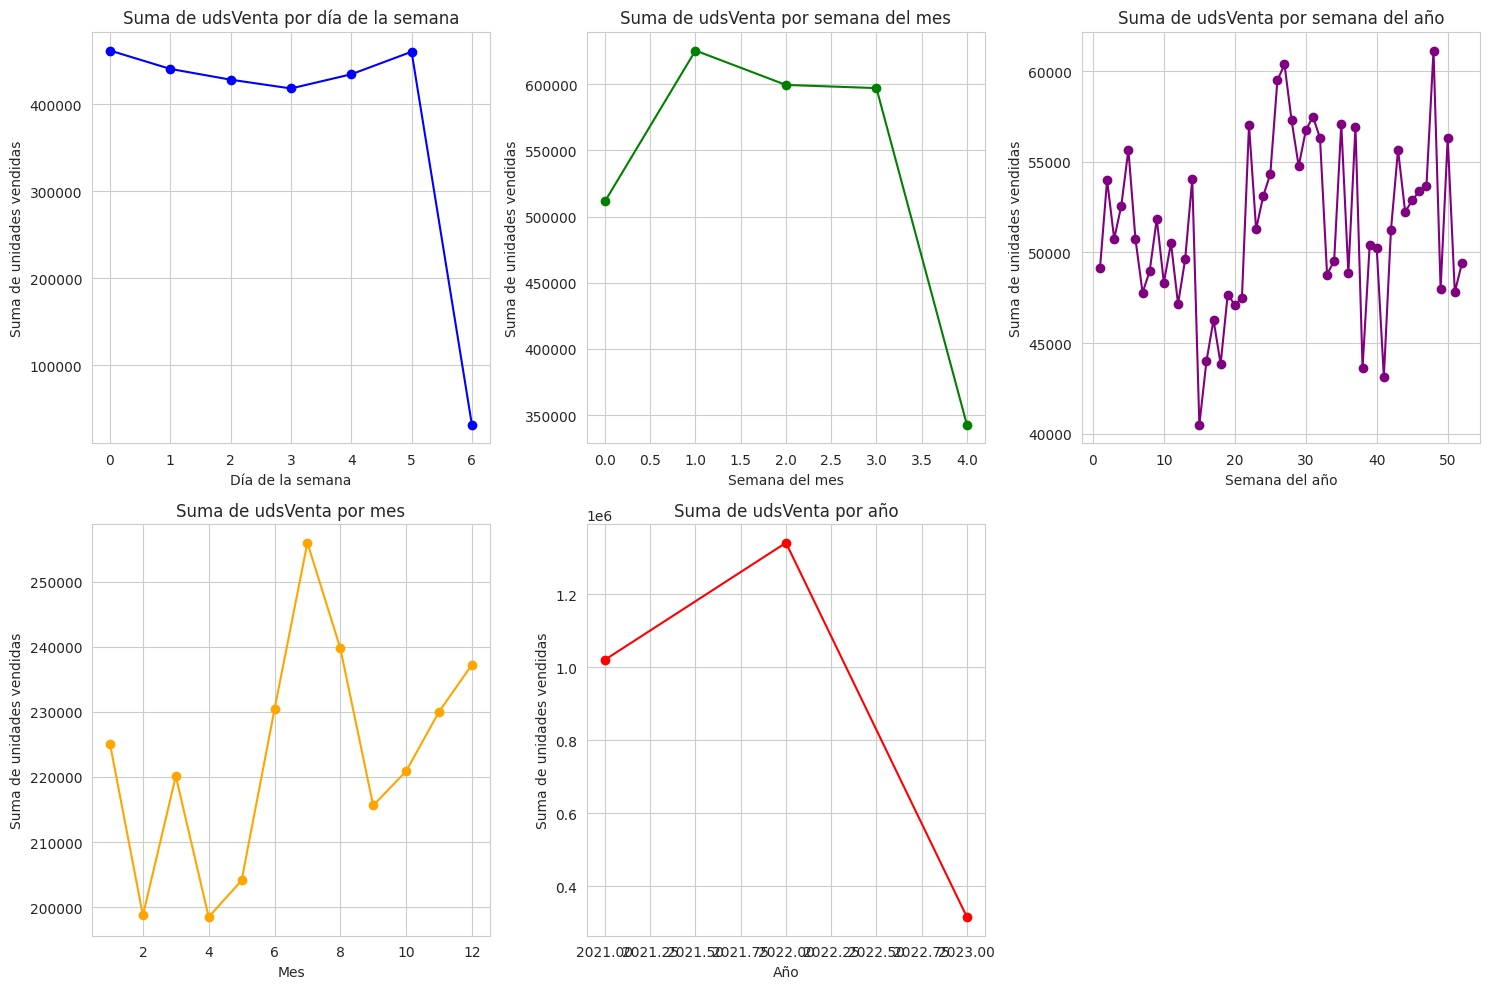

In [ ]:
# Calcular los sumatorios de unidades vendidas por día de la semana, semana del mes, semana del año, mes y año
sumatorio_por_dia_semana = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['dia_semana'])['udsVenta'].sum()
sumatorio_por_semana_mes = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['semana_mes'])['udsVenta'].sum()  # Calcula la semana del mes
sumatorio_por_semana_año = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['semana_año'])['udsVenta'].sum()  # Calcula la semana del año
sumatorio_por_mes = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['mes'])['udsVenta'].sum()
sumatorio_por_año = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['año'])['udsVenta'].sum()

# Configurar el estilo y tamaño de las gráficas
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# Graficar el sumatorio de unidades vendidas por día de la semana
plt.subplot(2, 3, 1)
plt.plot(sumatorio_por_dia_semana.index, sumatorio_por_dia_semana.values, marker='o', color='blue')
plt.title('Suma de udsVenta por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Suma de unidades vendidas')

# Graficar el sumatorio de unidades vendidas por semana del mes
plt.subplot(2, 3, 2)
plt.plot(sumatorio_por_semana_mes.index, sumatorio_por_semana_mes.values, marker='o', color='green')
plt.title('Suma de udsVenta por semana del mes')
plt.xlabel('Semana del mes')
plt.ylabel('Suma de unidades vendidas')

# Graficar el sumatorio de unidades vendidas por semana del año
plt.subplot(2, 3, 3)
plt.plot(sumatorio_por_semana_año.index, sumatorio_por_semana_año.values, marker='o', color='purple')
plt.title('Suma de udsVenta por semana del año')
plt.xlabel('Semana del año')
plt.ylabel('Suma de unidades vendidas')

# Graficar el sumatorio de unidades vendidas por mes
plt.subplot(2, 3, 4)
plt.plot(sumatorio_por_mes.index, sumatorio_por_mes.values, marker='o', color='orange')
plt.title('Suma de udsVenta por mes')
plt.xlabel('Mes')
plt.ylabel('Suma de unidades vendidas')

# Graficar el sumatorio de unidades vendidas por año
plt.subplot(2, 3, 5)
plt.plot(sumatorio_por_año.index, sumatorio_por_año.values, marker='o', color='red')
plt.title('Suma de udsVenta por año')
plt.xlabel('Año')
plt.ylabel('Suma de unidades vendidas')

plt.tight_layout()
plt.show()


<ipython-input-71-dad15e6a2b0c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sumatorio_por_promocion, x='estaEnPromocion', y='udsVenta', palette=['blue', 'orange'])


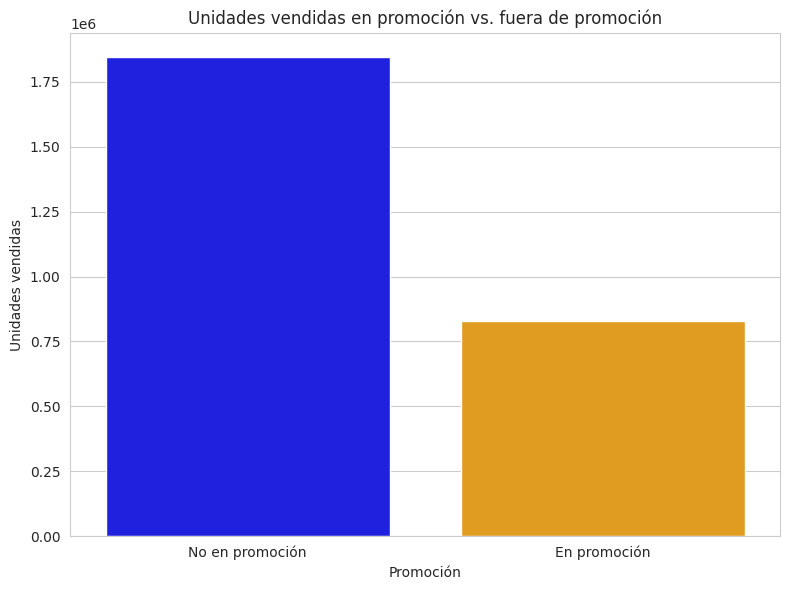

In [ ]:
# Calcular los sumatorios de unidades vendidas por si están en promoción
sumatorio_por_promocion = data_ventas_stock_calendario.groupby('estaEnPromocion')['udsVenta'].sum().reset_index()

# Configurar el estilo y tamaño de la gráfica
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Graficar las unidades vendidas por promoción
sns.barplot(data=sumatorio_por_promocion, x='estaEnPromocion', y='udsVenta', palette=['blue', 'orange'])
plt.title('Unidades vendidas en promoción vs. fuera de promoción')
plt.xlabel('Promoción')
plt.ylabel('Unidades vendidas')
plt.xticks([0, 1], ['No en promoción', 'En promoción'])

plt.tight_layout()
plt.show()


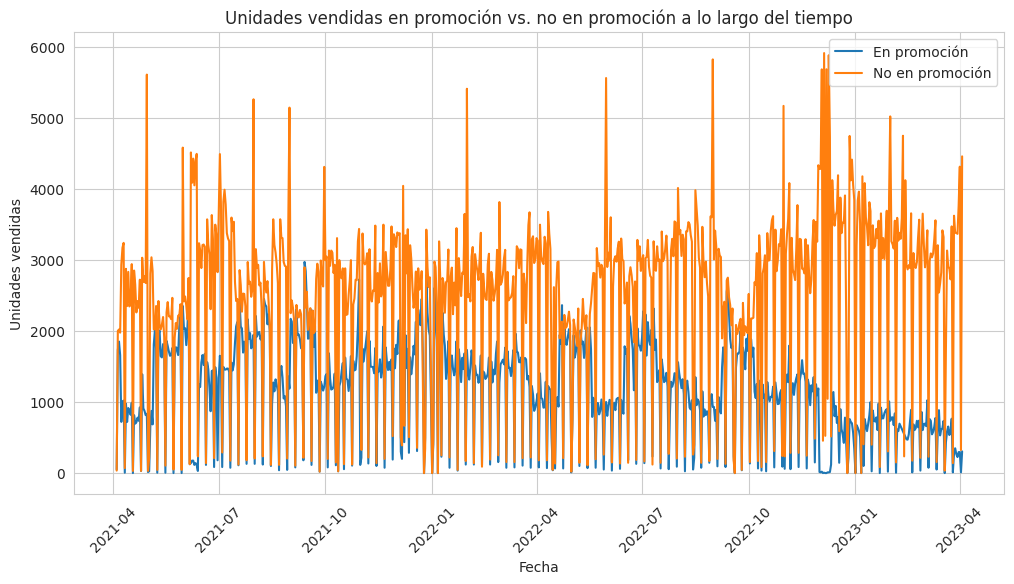

In [ ]:
# Filtrar los datos de ventas en promoción y fuera de promoción
ventas_en_promocion = data_ventas_stock_calendario[data_ventas_stock_calendario['estaEnPromocion'] == 1]
ventas_fuera_de_promocion = data_ventas_stock_calendario[data_ventas_stock_calendario['estaEnPromocion'] == 0]

# Calcular el sumatorio de unidades vendidas por fecha para cada categoría
sumatorio_ventas_en_promocion = ventas_en_promocion.groupby('idSecuencia')['udsVenta'].sum().reset_index()
sumatorio_ventas_fuera_de_promocion = ventas_fuera_de_promocion.groupby('idSecuencia')['udsVenta'].sum().reset_index()

# Configurar el estilo de Seaborn
sns.set_style("whitegrid")

# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Graficar las unidades vendidas en promoción
sns.lineplot(data=sumatorio_ventas_en_promocion, x='idSecuencia', y='udsVenta', label='En promoción')

# Graficar las unidades vendidas fuera de promoción
sns.lineplot(data=sumatorio_ventas_fuera_de_promocion, x='idSecuencia', y='udsVenta', label='No en promoción')

# Configurar etiquetas y título
plt.title('Unidades vendidas en promoción vs. no en promoción a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45)

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

Vamos a comprobar si existe algún tipo de estacionalidad, tendencia o heterocedasticidad.

<ipython-input-73-544010d7a349>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='idSecuencia', y='udsVenta', data=data_ventas_stock_calendario, ci=None)


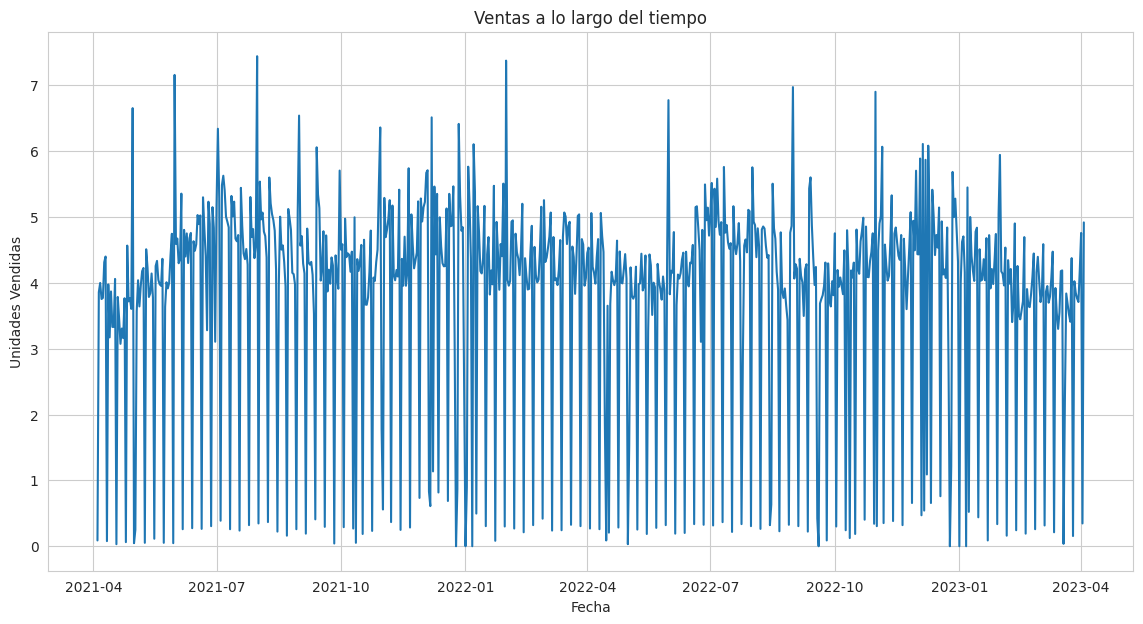

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='idSecuencia', y='udsVenta', data=data_ventas_stock_calendario, ci=None)
plt.title('Ventas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Unidades Vendidas')
plt.show()

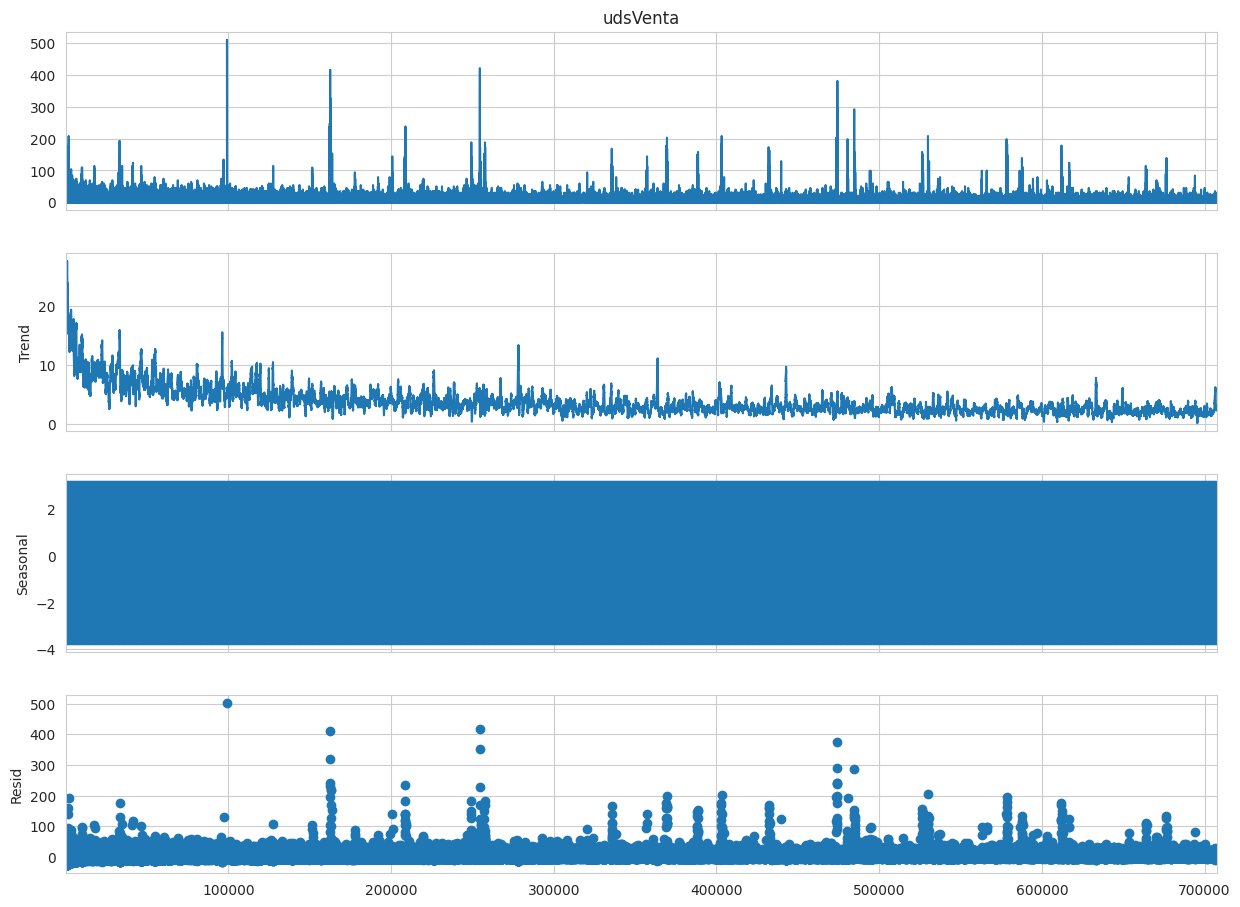

In [ ]:
# Descomposición de la serie temporal
decomposition = sm.tsa.seasonal_decompose(data_ventas_stock_calendario['udsVenta'], model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()


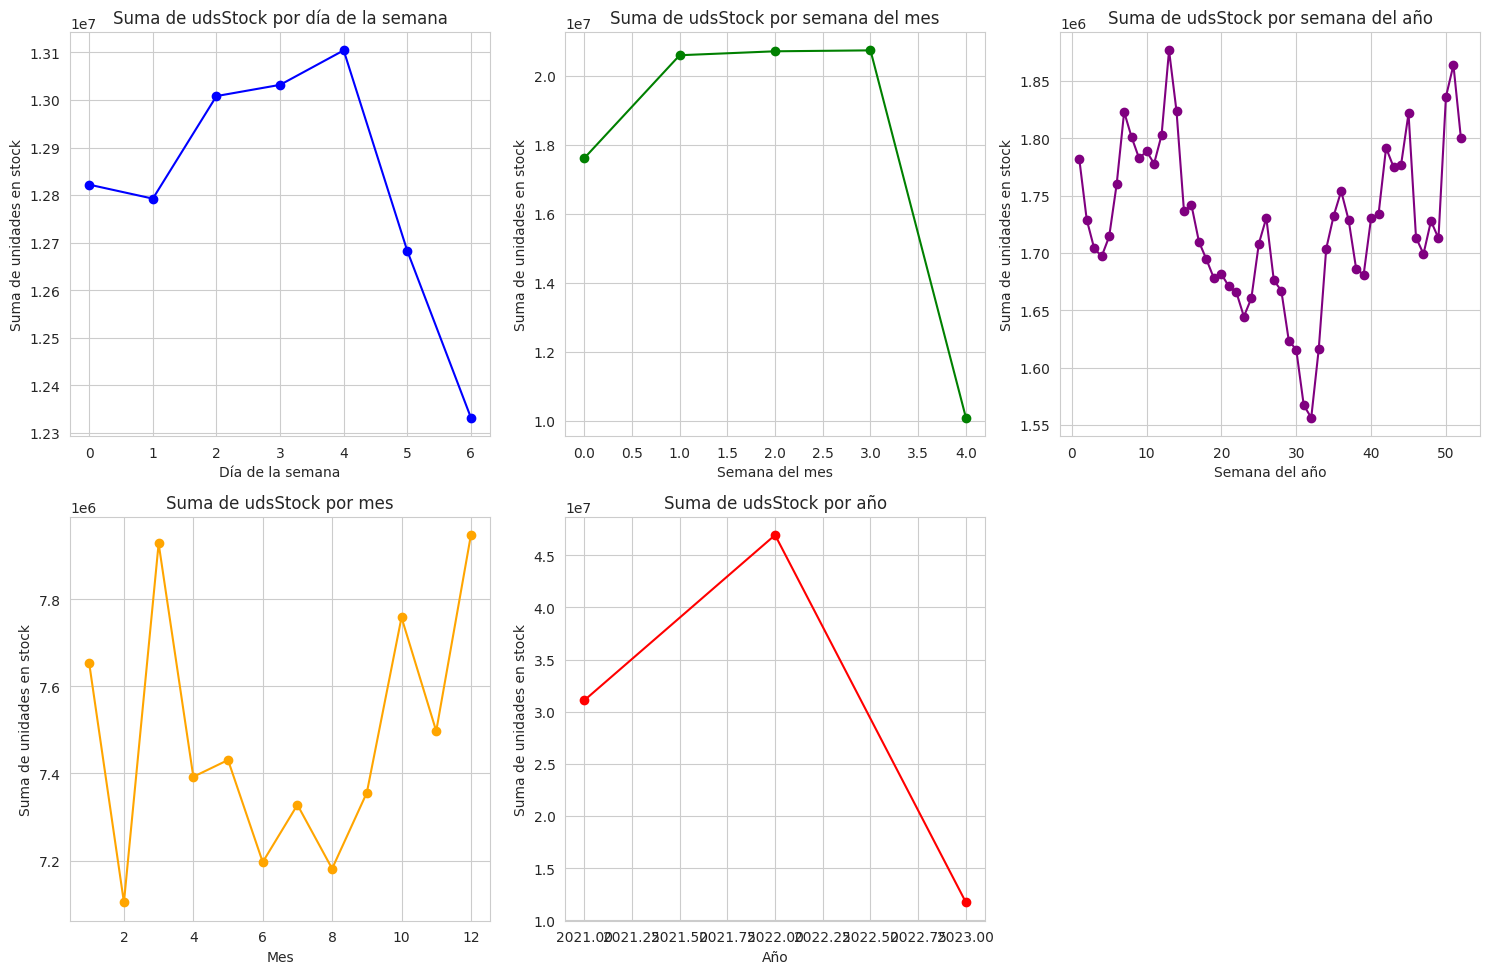

In [ ]:
# Calcular los sumatorios de unidades en stock por día de la semana, semana del mes, semana del año, mes y año
sumatorio_por_dia_semana = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['dia_semana'])['udsStock'].sum()
sumatorio_por_semana_mes = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['semana_mes'])['udsStock'].sum()  # Calcula la semana del mes
sumatorio_por_semana_año = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['semana_año'])['udsStock'].sum()  # Calcula la semana del año
sumatorio_por_mes = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['mes'])['udsStock'].sum()
sumatorio_por_año = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['año'])['udsStock'].sum()

# Configurar el estilo y tamaño de las gráficas
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# Graficar el sumatorio de unidades en stock por día de la semana
plt.subplot(2, 3, 1)
plt.plot(sumatorio_por_dia_semana.index, sumatorio_por_dia_semana.values, marker='o', color='blue')
plt.title('Suma de udsStock por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Suma de unidades en stock')

# Graficar el sumatorio de unidades en stock por semana del mes
plt.subplot(2, 3, 2)
plt.plot(sumatorio_por_semana_mes.index, sumatorio_por_semana_mes.values, marker='o', color='green')
plt.title('Suma de udsStock por semana del mes')
plt.xlabel('Semana del mes')
plt.ylabel('Suma de unidades en stock')

# Graficar el sumatorio de unidades en stock por semana del año
plt.subplot(2, 3, 3)
plt.plot(sumatorio_por_semana_año.index, sumatorio_por_semana_año.values, marker='o', color='purple')
plt.title('Suma de udsStock por semana del año')
plt.xlabel('Semana del año')
plt.ylabel('Suma de unidades en stock')

# Graficar el sumatorio de unidades en stock por mes
plt.subplot(2, 3, 4)
plt.plot(sumatorio_por_mes.index, sumatorio_por_mes.values, marker='o', color='orange')
plt.title('Suma de udsStock por mes')
plt.xlabel('Mes')
plt.ylabel('Suma de unidades en stock')

# Graficar el sumatorio de unidades en stock por año
plt.subplot(2, 3, 5)
plt.plot(sumatorio_por_año.index, sumatorio_por_año.values, marker='o', color='red')
plt.title('Suma de udsStock por año')
plt.xlabel('Año')
plt.ylabel('Suma de unidades en stock')

plt.tight_layout()
plt.show()

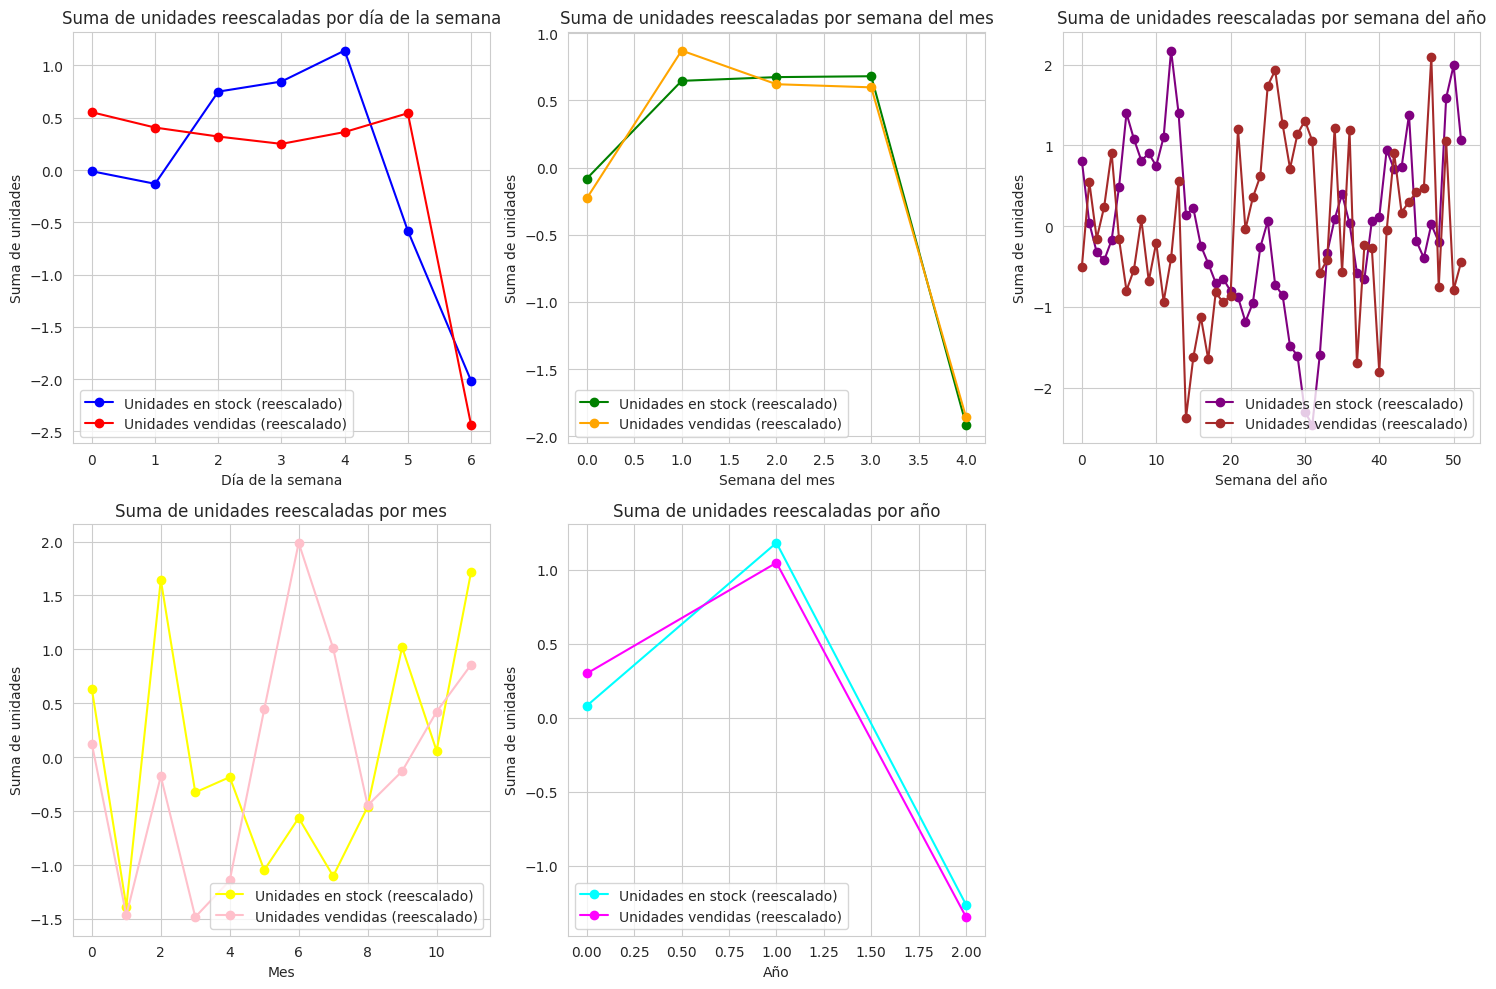

In [ ]:
# Calcular los sumatorios de unidades en stock y unidades vendidas por día de la semana, semana del mes, semana del año, mes y año
sumatorio_uds_stock_por_dia_semana = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.dayofweek)['udsStock'].sum()
sumatorio_uds_venta_por_dia_semana = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.dayofweek)['udsVenta'].sum()
sumatorio_uds_stock_por_semana_mes = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.day // 7)['udsStock'].sum()  # Calcula la semana del mes
sumatorio_uds_venta_por_semana_mes = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.day // 7)['udsVenta'].sum()  # Calcula la semana del mes
sumatorio_uds_stock_por_semana_año = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.isocalendar().week)['udsStock'].sum()  # Calcula la semana del año
sumatorio_uds_venta_por_semana_año = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.isocalendar().week)['udsVenta'].sum()  # Calcula la semana del año
sumatorio_uds_stock_por_mes = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.month)['udsStock'].sum()
sumatorio_uds_venta_por_mes = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.month)['udsVenta'].sum()
sumatorio_uds_stock_por_año = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.year)['udsStock'].sum()
sumatorio_uds_venta_por_año = data_ventas_stock_calendario.groupby(data_ventas_stock_calendario['idSecuencia'].dt.year)['udsVenta'].sum()

# Reescalar los datos
scaler = StandardScaler()

sumatorio_uds_stock_por_dia_semana_reescalado = scaler.fit_transform(sumatorio_uds_stock_por_dia_semana.values.reshape(-1, 1)).flatten()
sumatorio_uds_venta_por_dia_semana_reescalado = scaler.fit_transform(sumatorio_uds_venta_por_dia_semana.values.reshape(-1, 1)).flatten()
sumatorio_uds_stock_por_semana_mes_reescalado = scaler.fit_transform(sumatorio_uds_stock_por_semana_mes.values.reshape(-1, 1)).flatten()
sumatorio_uds_venta_por_semana_mes_reescalado = scaler.fit_transform(sumatorio_uds_venta_por_semana_mes.values.reshape(-1, 1)).flatten()
sumatorio_uds_stock_por_semana_año_reescalado = scaler.fit_transform(sumatorio_uds_stock_por_semana_año.values.reshape(-1, 1)).flatten()
sumatorio_uds_venta_por_semana_año_reescalado = scaler.fit_transform(sumatorio_uds_venta_por_semana_año.values.reshape(-1, 1)).flatten()
sumatorio_uds_stock_por_mes_reescalado = scaler.fit_transform(sumatorio_uds_stock_por_mes.values.reshape(-1, 1)).flatten()
sumatorio_uds_venta_por_mes_reescalado = scaler.fit_transform(sumatorio_uds_venta_por_mes.values.reshape(-1, 1)).flatten()
sumatorio_uds_stock_por_año_reescalado = scaler.fit_transform(sumatorio_uds_stock_por_año.values.reshape(-1, 1)).flatten()
sumatorio_uds_venta_por_año_reescalado = scaler.fit_transform(sumatorio_uds_venta_por_año.values.reshape(-1, 1)).flatten()

# Configurar el estilo y tamaño de las gráficas
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# Graficar el sumatorio de unidades en stock y unidades vendidas por día de la semana
plt.subplot(2, 3, 1)
plt.plot(sumatorio_uds_stock_por_dia_semana_reescalado, marker='o', color='blue', label='Unidades en stock (reescalado)')
plt.plot(sumatorio_uds_venta_por_dia_semana_reescalado, marker='o', color='red', label='Unidades vendidas (reescalado)')
plt.title('Suma de unidades reescaladas por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Suma de unidades')
plt.legend()

# Graficar el sumatorio de unidades en stock y unidades vendidas por semana del mes
plt.subplot(2, 3, 2)
plt.plot(sumatorio_uds_stock_por_semana_mes_reescalado, marker='o', color='green', label='Unidades en stock (reescalado)')
plt.plot(sumatorio_uds_venta_por_semana_mes_reescalado, marker='o', color='orange', label='Unidades vendidas (reescalado)')
plt.title('Suma de unidades reescaladas por semana del mes')
plt.xlabel('Semana del mes')
plt.ylabel('Suma de unidades')
plt.legend()

# Graficar el sumatorio de unidades en stock y unidades vendidas por semana del año
plt.subplot(2, 3, 3)
plt.plot(sumatorio_uds_stock_por_semana_año_reescalado, marker='o', color='purple', label='Unidades en stock (reescalado)')
plt.plot(sumatorio_uds_venta_por_semana_año_reescalado, marker='o', color='brown', label='Unidades vendidas (reescalado)')
plt.title('Suma de unidades reescaladas por semana del año')
plt.xlabel('Semana del año')
plt.ylabel('Suma de unidades')
plt.legend()

# Graficar el sumatorio de unidades en stock y unidades vendidas por mes
plt.subplot(2, 3, 4)
plt.plot(sumatorio_uds_stock_por_mes_reescalado, marker='o', color='yellow', label='Unidades en stock (reescalado)')
plt.plot(sumatorio_uds_venta_por_mes_reescalado, marker='o', color='pink', label='Unidades vendidas (reescalado)')
plt.title('Suma de unidades reescaladas por mes')
plt.xlabel('Mes')
plt.ylabel('Suma de unidades')
plt.legend()

# Graficar el sumatorio de unidades en stock y unidades vendidas por año
plt.subplot(2, 3, 5)
plt.plot(sumatorio_uds_stock_por_año_reescalado, marker='o', color='cyan', label='Unidades en stock (reescalado)')
plt.plot(sumatorio_uds_venta_por_año_reescalado, marker='o', color='magenta', label='Unidades vendidas (reescalado)')
plt.title('Suma de unidades reescaladas por año')
plt.xlabel('Año')
plt.ylabel('Suma de unidades')
plt.legend()

plt.tight_layout()
plt.show()


Ventas en apertura/clausura y festivos

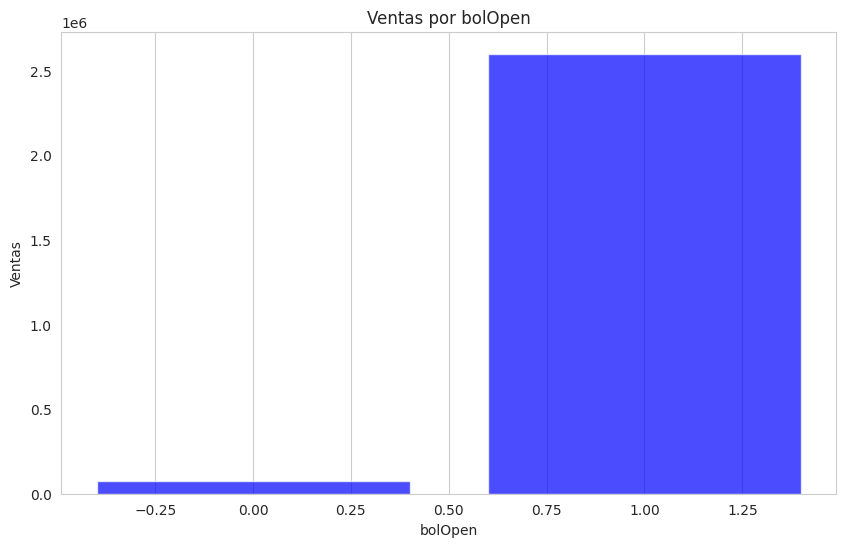

In [ ]:
# Graficar las ventas por bolOpen usando un gráfico de barras
ventas_por_bolOpen = data_ventas_stock_calendario.groupby('bolOpen')['udsVenta'].sum().reset_index()


plt.figure(figsize=(10, 6))
plt.bar(ventas_por_bolOpen['bolOpen'], ventas_por_bolOpen['udsVenta'], color='blue', alpha=0.7)
plt.title('Ventas por bolOpen')
plt.xlabel('bolOpen')
plt.ylabel('Ventas')
plt.grid(axis='y')
plt.show()


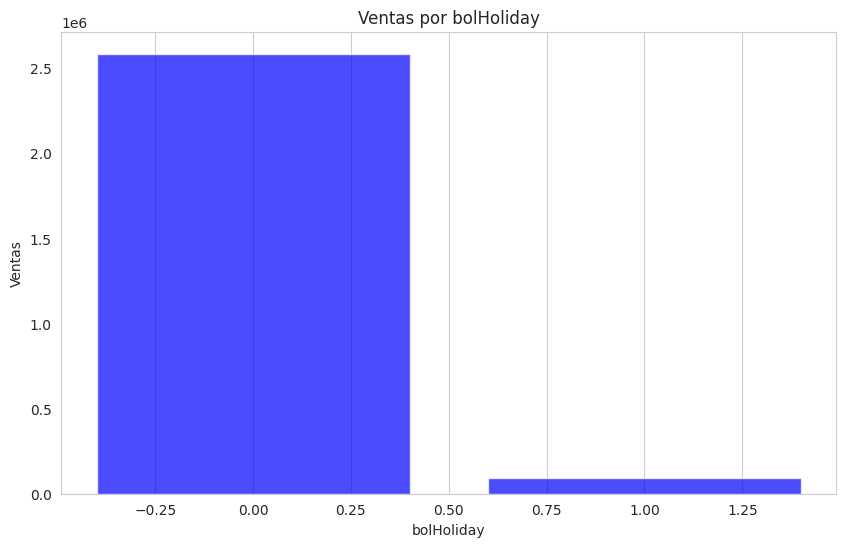

In [ ]:
# Graficar las ventas por bolHoliday usando un gráfico de barras
ventas_por_bolHoliday = data_ventas_stock_calendario.groupby('bolHoliday')['udsVenta'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(ventas_por_bolHoliday['bolHoliday'], ventas_por_bolHoliday['udsVenta'], color='blue', alpha=0.7)
plt.title('Ventas por bolHoliday')
plt.xlabel('bolHoliday')
plt.ylabel('Ventas')
plt.grid(axis='y')
plt.show()

In [ ]:
data_ventas_stock_calendario[(data_ventas_stock_calendario['bolOpen'] == 0) & (data_ventas_stock_calendario['udsVenta'] != 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año
162,1,2021-09-12,5,277,0,1,0,2021,9,12,6,1,36
368,1,2022-04-06,5,450,0,1,0,2022,4,6,2,0,14
375,1,2022-04-13,30,624,0,1,0,2022,4,13,2,1,15
382,1,2022-04-20,35,441,0,1,0,2022,4,20,2,2,16
389,1,2022-04-27,25,639,0,1,1,2022,4,27,2,3,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
706939,1000,2021-06-04,5,59,0,1,0,2021,6,4,4,0,22
707038,1000,2021-09-11,5,64,0,1,0,2021,9,11,5,1,36
707259,1000,2022-04-20,5,114,0,1,0,2022,4,20,2,2,16
707266,1000,2022-04-27,10,109,0,1,0,2022,4,27,2,3,17


In [ ]:
data_ventas_stock_calendario[(data_ventas_stock_calendario['idSecuencia'] == datetime(2021, 9, 1))]


,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año
151,1,2021-09-01,20,460,1,0,0,2021,9,1,2,0,35
882,2,2021-09-01,35,777,1,0,0,2021,9,1,2,0,35
1613,3,2021-09-01,15,15,1,0,0,2021,9,1,2,0,35
2344,4,2021-09-01,0,238,1,0,0,2021,9,1,2,0,35
3075,5,2021-09-01,54,431,1,0,0,2021,9,1,2,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
704104,996,2021-09-01,5,79,1,0,0,2021,9,1,2,0,35
704835,997,2021-09-01,0,94,1,0,1,2021,9,1,2,0,35
705566,998,2021-09-01,0,99,1,0,1,2021,9,1,2,0,35
706297,999,2021-09-01,5,119,1,0,1,2021,9,1,2,0,35


Existen ventas en festivos y cuando el punto de venta está cerrado, pero no vamos a realizar ningún cambio al respecto.


In [ ]:
data_ventas_stock_calendario[(data_ventas_stock_calendario['bolHoliday'] == 1) & (data_ventas_stock_calendario['udsVenta'] != 0)]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,estaEnPromocion,año,mes,dia,dia_semana,semana_mes,semana_año
162,1,2021-09-12,5,277,0,1,0,2021,9,12,6,1,36
249,1,2021-12-08,5,267,1,1,1,2021,12,8,2,1,49
253,1,2021-12-12,5,495,1,1,1,2021,12,12,6,1,49
368,1,2022-04-06,5,450,0,1,0,2022,4,6,2,0,14
375,1,2022-04-13,30,624,0,1,0,2022,4,13,2,1,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
706939,1000,2021-06-04,5,59,0,1,0,2021,6,4,4,0,22
707038,1000,2021-09-11,5,64,0,1,0,2021,9,11,5,1,36
707259,1000,2022-04-20,5,114,0,1,0,2022,4,20,2,2,16
707266,1000,2022-04-27,10,109,0,1,0,2022,4,27,2,3,17


Se identifica un patrón donde el stock disminuye notablemente hacia el final de la semana, especialmente entre los días 5 y 6, preparándose para un incremento en las ventas. Aunque las ventas disminuyen menos abruptamente, esto indica ajustes de stock en anticipación a cambios en la demanda. Durante las semanas del mes, tanto el stock como las ventas se mantienen estables hasta la cuarta semana, lo que puede reflejar una estrategia para minimizar el exceso de inventario al final del mes. A nivel anual, las fluctuaciones son más marcadas, revelando la influencia de factores estacionales o eventos específicos, con picos de stock que usualmente preceden a los picos de ventas. El análisis por mes muestra una gestión activa del inventario en respuesta a las tendencias de ventas anticipadas. En cuanto a las ventas anuales, el gráfico coincide con la confirmación que tenemos sobre que el único año completo que tenemos es el segundo.

Ahora veremos las correlaciones entre diferentes columnas.

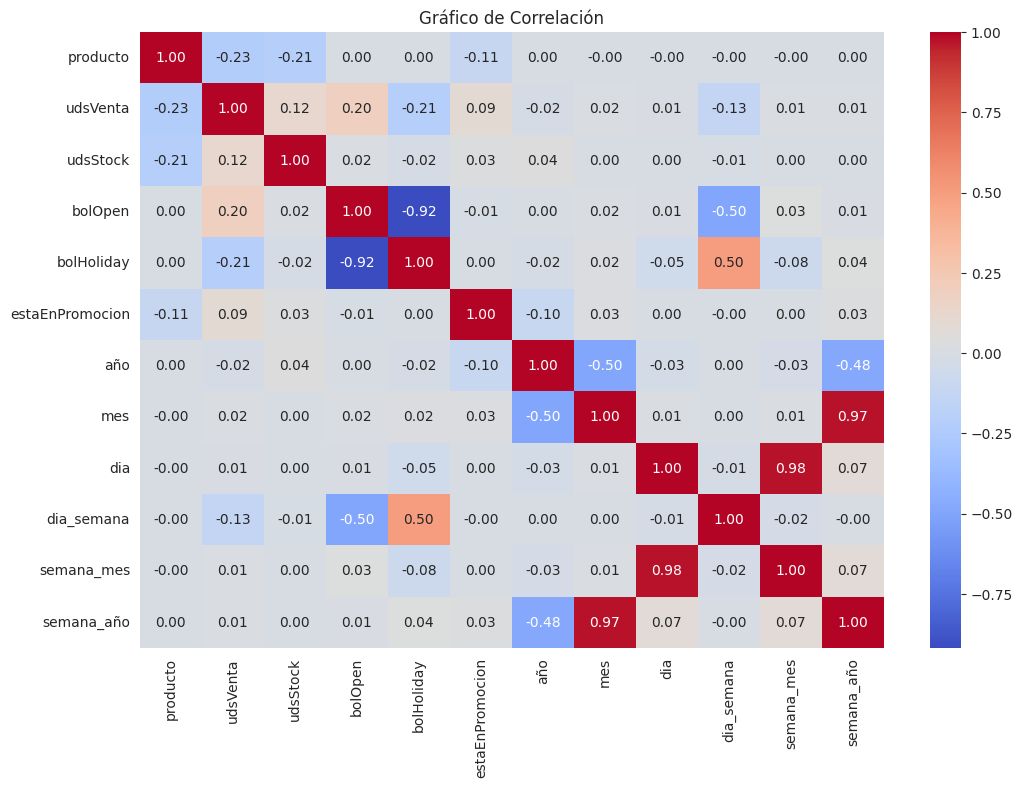

In [ ]:
# Primero, necesitamos quitar las columnas no numéricas
data_numerica = data_ventas_stock_calendario.drop(['idSecuencia'], axis=1)

# Calcular la matriz de correlación
correlation_matrix = data_numerica.corr()

# Crear un mapa de calor con la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Gráfico de Correlación')
plt.show()

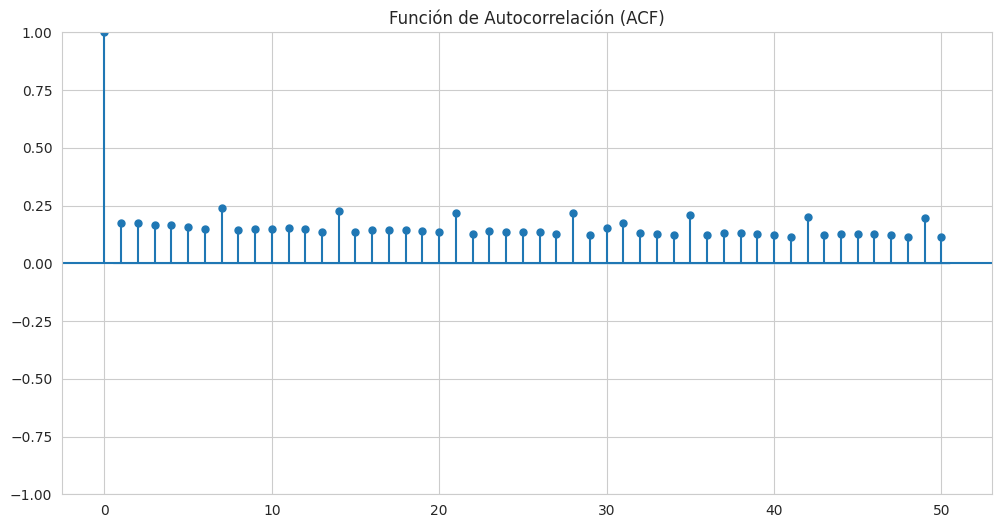

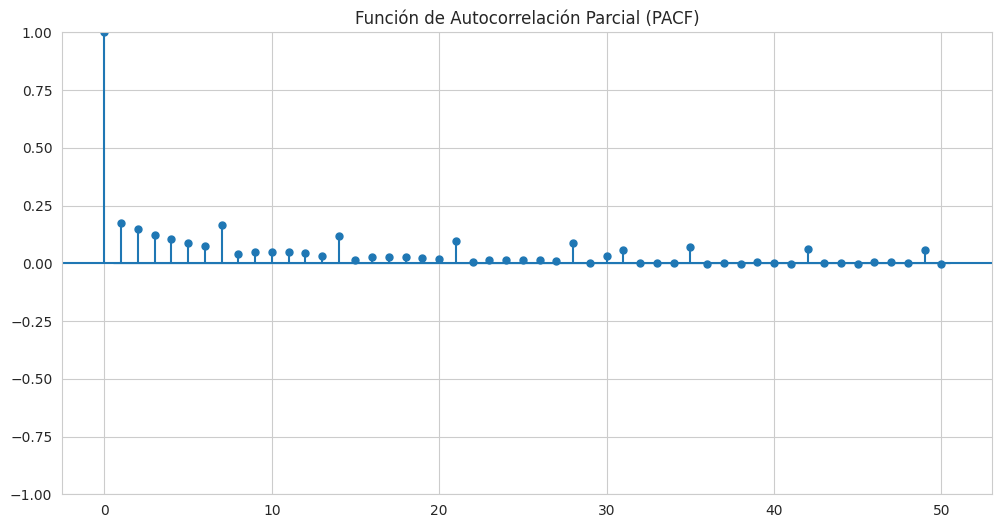

In [ ]:
# Seleccionar la columna de la serie temporal
serie_temporal = data_numerica['udsVenta']

# Graficar la ACF
plt.figure(figsize=(12, 6))
plot_acf(serie_temporal, lags=50, ax=plt.gca())
plt.title('Función de Autocorrelación (ACF)')
plt.show()

# Graficar la PACF
plt.figure(figsize=(12, 6))
plot_pacf(serie_temporal, lags=50, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

# **Export de datos**

In [ ]:
data_ventas_stock_calendario.to_csv (r'/content/drive/Othercomputers/Mi portátil/UOC/4o Semestre/TFM/Datos/data_ventas_stock_calendario_joined.csv', index = None, header=True)